# Downloading data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/fabric_detect_dataset/dataset.zip /content/dataset.zip

In [ ]:
!unzip /content/dataset.zip
# !rm -rf /content/textiledefectdetection.zip /content/sample_data

Streaming output truncated to the last 5000 lines.
  inflating: content/dataset/train/hole/46992.jpeg  
  inflating: content/dataset/train/hole/43180.jpeg  
  inflating: content/dataset/train/hole/42465.jpeg  
  inflating: content/dataset/train/hole/45556.jpeg  
  inflating: content/dataset/train/hole/43664.jpeg  
  inflating: content/dataset/train/hole/38286.jpeg  
  inflating: content/dataset/train/hole/47920.jpeg  
  inflating: content/dataset/train/hole/44196.jpeg  
  inflating: content/dataset/train/hole/39945.jpeg  
  inflating: content/dataset/train/hole/36089.jpeg  
  inflating: content/dataset/train/hole/36760.jpeg  
  inflating: content/dataset/train/hole/45874.jpeg  
  inflating: content/dataset/train/hole/37755.jpeg  
  inflating: content/dataset/train/hole/44250.jpeg  
  inflating: content/dataset/train/hole/47383.jpeg  
  inflating: content/dataset/train/hole/46134.jpeg  
  inflating: content/dataset/train/hole/43934.jpeg  
  inflating: content/dataset/train/hole/37959.jp

In [ ]:
!mv /content/content/dataset /content/dataset && rm -rf /content/content

In [ ]:
!du -sh /content/dataset

567M	/content/dataset


In [ ]:
import os
import uuid

# List of image extensions to process
IMAGE_EXTENSIONS = {'.jpg', '.jpeg', '.png'}

def rename_image_files(IMAGE_DIR):
    for filename in os.listdir(IMAGE_DIR):
        src_path = os.path.join(IMAGE_DIR, filename)
        # Skip directories
        if not os.path.isfile(src_path):
            continue
        # Extract extension
        name, ext = os.path.splitext(filename)
        # Only process if it's an image
        if ext.lower() in IMAGE_EXTENSIONS:
            # Generate a new UUID-based filename
            new_filename = f"{uuid.uuid4()}{ext.lower()}"
            dst_path = os.path.join(IMAGE_DIR, new_filename)
            # Rename the file
            os.rename(src_path, dst_path)
            # print(f"Renamed: {filename} -> {new_filename}")

    print("Done renaming images.")

In [ ]:
rename_image_files(IMAGE_DIR = '/content/dataset/test/color')
rename_image_files(IMAGE_DIR = '/content/dataset/test/cut')
rename_image_files(IMAGE_DIR = '/content/dataset/test/good')
rename_image_files(IMAGE_DIR = '/content/dataset/test/hole')
rename_image_files(IMAGE_DIR = '/content/dataset/test/metal_contamination')


rename_image_files(IMAGE_DIR = '/content/dataset/train/color')
rename_image_files(IMAGE_DIR = '/content/dataset/train/cut')
rename_image_files(IMAGE_DIR = '/content/dataset/train/good')
rename_image_files(IMAGE_DIR = '/content/dataset/train/hole')
rename_image_files(IMAGE_DIR = '/content/dataset/train/metal_contamination')

Done renaming images.
Done renaming images.
Done renaming images.
Done renaming images.
Done renaming images.
Done renaming images.
Done renaming images.
Done renaming images.
Done renaming images.
Done renaming images.


In [ ]:
!rm -rf /content/data
!mkdir -p /content/data/train/good /content/data/train/defect /content/data/test/good /content/data/test/defect

# Move train files
!find /content/dataset/train/good -type f -exec mv -t /content/data/train/good {} +
!find /content/dataset/train/cut -type f -exec mv -t /content/data/train/defect {} +
!find /content/dataset/train/color -type f -exec mv -t /content/data/train/defect {} +
!find /content/dataset/train/metal_contamination -type f -exec mv -t /content/data/train/defect {} +
!find /content/dataset/train/hole -type f -exec mv -t /content/data/train/defect {} +

# Move test files
!find /content/dataset/test/good -type f -exec mv -t /content/data/test/good {} +
!find /content/dataset/test/cut -type f -exec mv -t /content/data/test/defect {} +
!find /content/dataset/test/color -type f -exec mv -t /content/data/test/defect {} +
!find /content/dataset/test/metal_contamination -type f -exec mv -t /content/data/test/defect {} +
!find /content/dataset/test/hole -type f -exec mv -t /content/data/test/defect {} +

!rm -rf /content/dataset


In [ ]:
!du -sh /content/data/

502M	/content/data/


# Prepare train and test data

In [ ]:
# Standard Libraries
import os
import shutil
import random
import time
from pathlib import Path
import warnings
import json

# Data Handling and Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
from PIL import Image
from tqdm import tqdm

# Sklearn Utilities
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

# TensorFlow
import tensorflow as tf

# Suppress warnings
warnings.filterwarnings("ignore")

# Print TensorFlow version
print(tf.__version__)

2.18.0


In [ ]:
!python -V

Python 3.11.13


In [ ]:
def split_data_into_train_test(data_dir, result_dir, train_ratio=0.8):
    if Path(result_dir).exists():
        shutil.rmtree(result_dir)
    classes = list(Path(data_dir).glob('*'))
    Path(result_dir).mkdir(parents=True, exist_ok=True)
    train_folder = Path(result_dir).joinpath('train')
    Path(train_folder).mkdir(parents=True, exist_ok=True)
    test_folder = Path(result_dir).joinpath('test')
    Path(test_folder).mkdir(parents=True, exist_ok=True)

    for class_folder in tqdm(classes):
        images = list(Path(class_folder).glob('*'))
        random.shuffle(images)

        split_index = int(len(images) * train_ratio)

        train_images = images[:split_index]
        test_images = images[split_index:]

        Path(train_folder, class_folder.name).mkdir(parents=True, exist_ok=True)
        Path(test_folder, class_folder.name).mkdir(parents=True, exist_ok=True)

        for idx,image_path in enumerate(train_images):
            src = image_path
            dst = Path(train_folder, class_folder.name, f"{idx+1}{image_path.suffix}")
            shutil.copy(src, dst)

        for idx,image_path in enumerate(test_images):
            src = image_path
            dst = Path(test_folder, class_folder.name, f"{idx+1}{image_path.suffix}")
            shutil.copy(src, dst)

In [ ]:
# data_dir = '/content/data'
# result_dir = '/content/data2'
# split_data_into_train_test(data_dir, result_dir, train_ratio=0.8)

In [ ]:
# !rm -rf /content/data && mv /content/data2 /content/data

In [ ]:
def remove_corrupted_files(dir_path):
    total_corrupted = 0
    all_paths = list(Path(dir_path).rglob('*'))
    for path in tqdm(all_paths):
        if path.is_file():
            try:
                Image.open(path)
            except Exception as e:
                os.remove(path)
                total_corrupted += 1
    print(f"\nTotal corrupted files: {total_corrupted}")

remove_corrupted_files('/content/data/train')
remove_corrupted_files('/content/data/test')

100%|██████████| 96002/96002 [00:06<00:00, 13987.88it/s]



Total corrupted files: 0


100%|██████████| 30002/30002 [00:02<00:00, 14808.11it/s]


Total corrupted files: 0


In [ ]:
train_path = Path('/content/data/train')
test_path = Path('/content/data/test')

n_classes = 0
n_len_training = 0
n_len_testing = 0
data = []

for class_dir in sorted(train_path.iterdir()):
    if class_dir.is_dir():
        class_name = class_dir.name
        n_classes += 1
        train_images = list(class_dir.iterdir())
        n_train_images = len(train_images)
        n_len_training += n_train_images
        data.append({
            'Class Name': class_name,
            'No of Training Images': n_train_images,
            'No of Testing Images': 0,  # Placeholder for now
            'Total Images': n_train_images  # Initial total with training images only
        })

for class_dir in sorted(test_path.iterdir()):
    if class_dir.is_dir():
        class_name = class_dir.name
        test_images = list(class_dir.iterdir())
        n_test_images = len(test_images)
        n_len_testing += n_test_images

        # Update corresponding entry in data list
        for entry in data:
            if entry['Class Name'] == class_name:
                entry['No of Testing Images'] = n_test_images
                entry['Total Images'] += n_test_images  # Update total images count
                break

# Create a DataFrame from the data list
df = pd.DataFrame(data)
df

,Class Name,No of Training Images,No of Testing Images,Total Images
0,defect,48000,24000,72000
1,good,48000,6000,54000


In [ ]:
def sample_class_images(folder_path, sample_size):
    # Convert folder_path to Path object
    folder_path = Path(folder_path)

    # Get list of class directories
    class_dirs = [d for d in folder_path.iterdir() if d.is_dir()]

    for class_dir in tqdm(list(class_dirs)):
        # Get list of image files in the class directory
        images = list(class_dir.glob('*.*'))

        num_images = len(images)

        if num_images > sample_size:
            # If more images than sample size, randomly remove some
            images_to_remove = random.sample(images, num_images - sample_size)
            for img_path in images_to_remove:
                img_path.unlink()  # Removes the file

        elif num_images < sample_size:
            # If fewer images than sample size, duplicate some images
            images_to_duplicate = random.choices(images, k=sample_size - num_images)
            for img_path in images_to_duplicate:
                new_img_path = class_dir / f"{img_path.stem}_dup{random.randint(1000, 9999)}{img_path.suffix}"
                shutil.copy2(img_path, new_img_path)

In [ ]:
train_folder_path = '/content/data/train'
sample_size = 500
sample_class_images(train_folder_path, sample_size)

test_folder_path = '/content/data/test'
sample_size = 100
sample_class_images(test_folder_path, sample_size)

100%|██████████| 2/2 [00:00<00:00,  2.11it/s]


In [ ]:
!du -sh /content/data/

14M	/content/data/


In [ ]:
!ls /content/data/train

defect	good


In [ ]:
!ls /content/data/test

defect	good


In [ ]:
!cp -r /content/data /content/data2

In [ ]:
import os
import random

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator,
    img_to_array,
    load_img,
    array_to_img
)

def augment_to_target(folder_path: str, target_per_class: int):
    """
    For each class-folder under folder_path, augment its images via horizontal/vertical flips
    until it contains target_per_class images.

    Args:
        folder_path (str): root directory containing one subfolder per class.
        target_per_class (int): desired number of images in each class folder.
    """
    # Only flips
    datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)

    for class_name in os.listdir(folder_path):
        class_dir = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_dir):
            continue

        # gather all image filepaths
        imgs = [
            os.path.join(class_dir, fn)
            for fn in os.listdir(class_dir)
            if fn.lower().endswith(('.png', '.jpg', '.jpeg'))
        ]
        count = len(imgs)
        print(f"Class '{class_name}': {count} originals, target = {target_per_class}")
        if count >= target_per_class:
            print("  → already at or above target, skipping.\n")
            continue

        needed = target_per_class - count
        print(f"  → need {needed} more; generating…")

        generated = 0
        while generated < needed:
            # pick a random base image
            img_path = random.choice(imgs)
            img = load_img(img_path)                  # PIL image
            x = img_to_array(img)                     # H×W×C numpy array
            x = np.expand_dims(x, 0)                  # make batch size=1

            # get one augmented sample
            aug_iter = datagen.flow(x, batch_size=1)
            aug_image = next(aug_iter)[0].astype('uint8')
            aug_pil   = array_to_img(aug_image)

            # build a unique filename
            base_name = os.path.splitext(os.path.basename(img_path))[0]
            save_name = f"aug_{base_name}_{generated:04d}.png"
            save_path = os.path.join(class_dir, save_name)

            aug_pil.save(save_path)
            generated += 1

        print(f"  → done generating {needed} images.\n")

In [ ]:
augment_to_target("/content/data/train", target_per_class=1000)
augment_to_target("/content/data/test",  target_per_class= 300)

Class 'defect': 500 originals, target = 1000
  → need 500 more; generating…
  → done generating 500 images.

Class 'good': 500 originals, target = 1000
  → need 500 more; generating…
  → done generating 500 images.

Class 'defect': 100 originals, target = 300
  → need 200 more; generating…
  → done generating 200 images.

Class 'good': 100 originals, target = 300
  → need 200 more; generating…
  → done generating 200 images.



# Exploring data

In [ ]:
train_path = Path('/content/data/train')
test_path = Path('/content/data/test')

n_classes = 0
n_len_training = 0
n_len_testing = 0
data = []

for class_dir in sorted(train_path.iterdir()):
    if class_dir.is_dir():
        class_name = class_dir.name
        n_classes += 1
        train_images = list(class_dir.iterdir())
        n_train_images = len(train_images)
        n_len_training += n_train_images
        data.append({
            'Class Name': class_name,
            'No of Training Images': n_train_images,
            'No of Testing Images': 0,  # Placeholder for now
            'Total Images': n_train_images  # Initial total with training images only
        })

for class_dir in sorted(test_path.iterdir()):
    if class_dir.is_dir():
        class_name = class_dir.name
        test_images = list(class_dir.iterdir())
        n_test_images = len(test_images)
        n_len_testing += n_test_images

        # Update corresponding entry in data list
        for entry in data:
            if entry['Class Name'] == class_name:
                entry['No of Testing Images'] = n_test_images
                entry['Total Images'] += n_test_images  # Update total images count
                break

# Create a DataFrame from the data list
df = pd.DataFrame(data)
df

,Class Name,No of Training Images,No of Testing Images,Total Images
0,defect,1000,300,1300
1,good,1000,300,1300


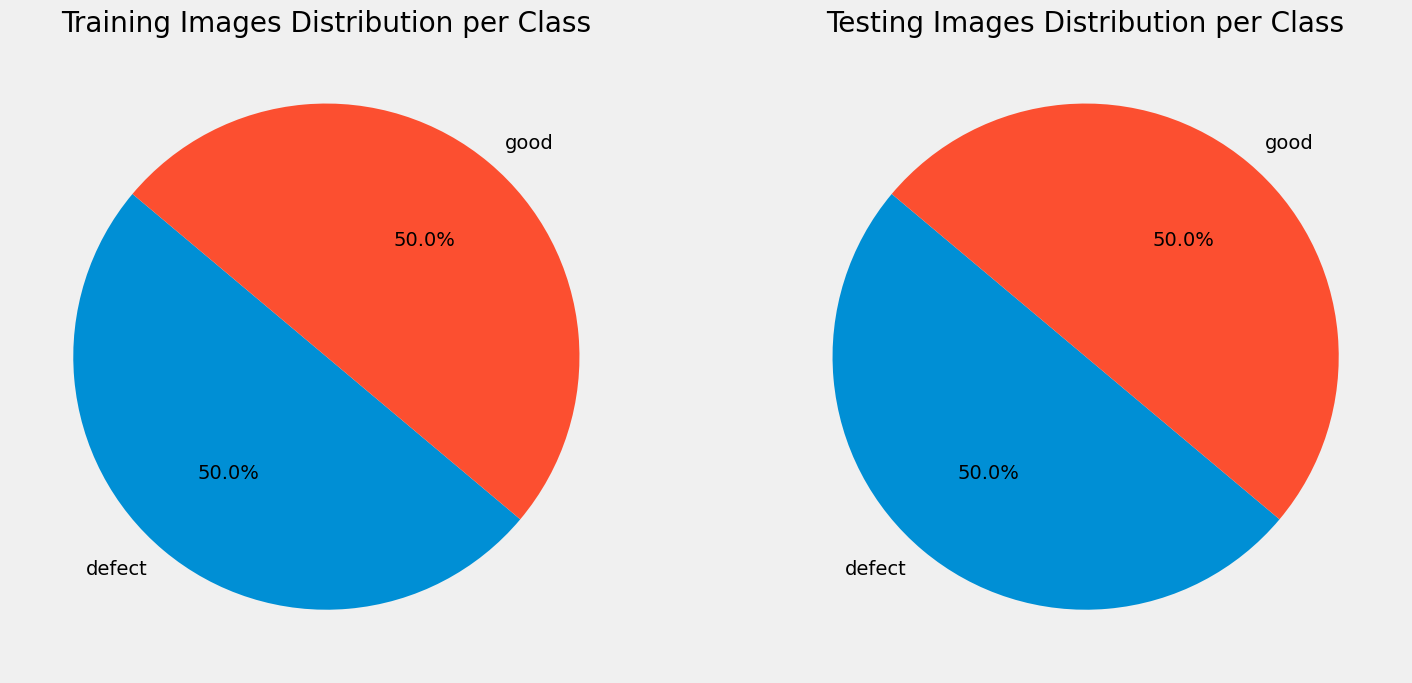

In [ ]:
# Apply fivethirtyeight style
plt.style.use('fivethirtyeight')

# Create a figure with subplots for pie charts
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Pie Chart for Training Images per Class
axs[0].pie(df['No of Training Images'], labels=df['Class Name'], autopct='%1.1f%%', startangle=140)
axs[0].set_title('Training Images Distribution per Class')

# Pie Chart for Testing Images per Class
axs[1].pie(df['No of Testing Images'], labels=df['Class Name'], autopct='%1.1f%%', startangle=140)
axs[1].set_title('Testing Images Distribution per Class')

plt.show()

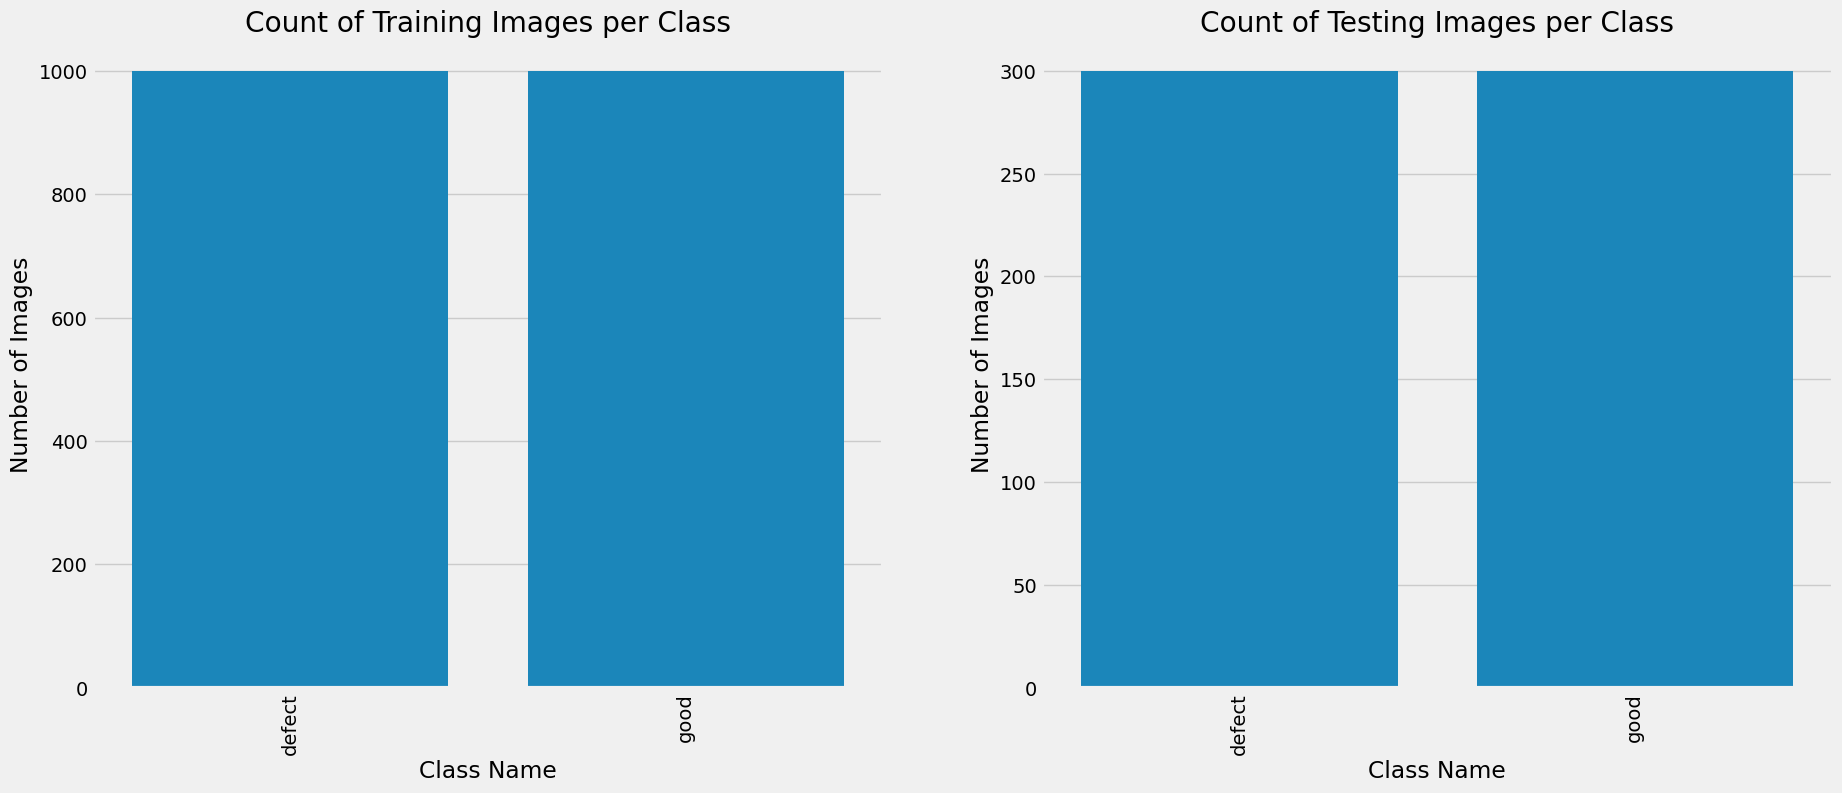

In [ ]:
# Create a figure with subplots for bar plots
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Barplot for Training Images per Class
sns.barplot(data=df, x='Class Name', y='No of Training Images', ax=axs[0])
axs[0].set_title('Count of Training Images per Class')
axs[0].set_ylabel('Number of Images')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)

# Barplot for Testing Images per Class
sns.barplot(data=df, x='Class Name', y='No of Testing Images', ax=axs[1])
axs[1].set_title('Count of Testing Images per Class')
axs[1].set_ylabel('Number of Images')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)

plt.show()

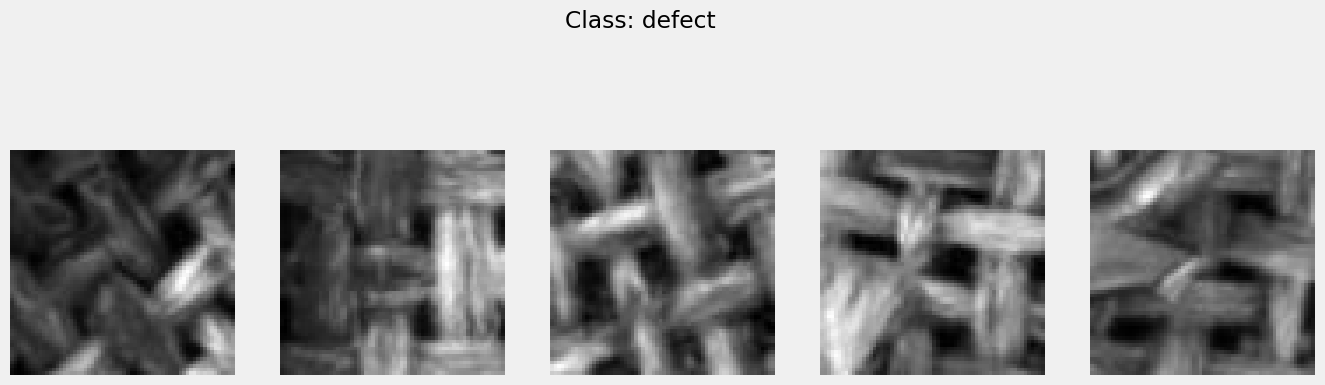

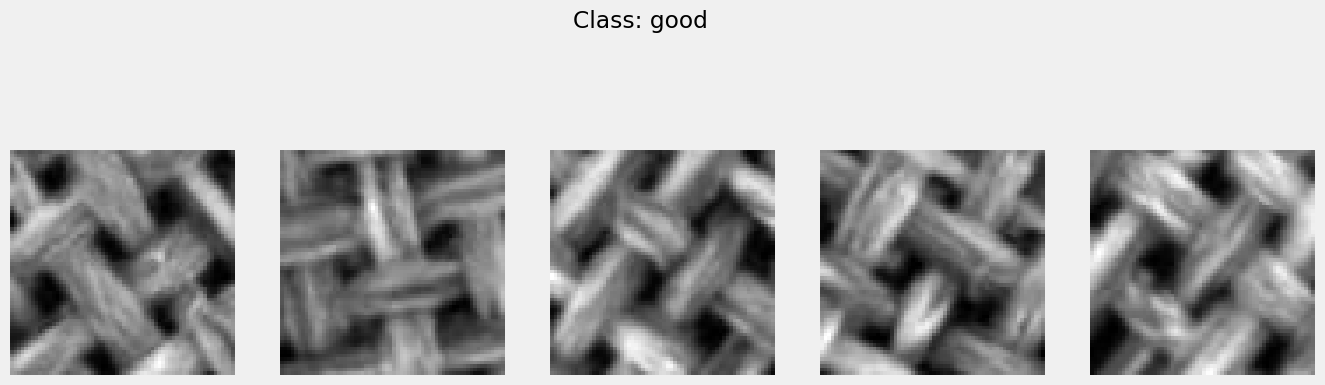

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os

def display_images_from_classes(folder_path, num_images=5):
    classes = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]
    for class_name in classes:
        class_path = os.path.join(folder_path, class_name)
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))]

        selected_images = images[:num_images]
        plt.figure(figsize=(15, 5))
        for i, image_name in enumerate(selected_images):
            img_path = os.path.join(class_path, image_name)
            # print(img_path)
            try:
                img = Image.open(img_path)
                plt.subplot(1, num_images, i + 1)
                plt.imshow(img)
                plt.axis('off')
            except Exception as e:
                print(f"Failed to open {img_path}: {e}")

        plt.suptitle(f'Class: {class_name}')
        plt.show()

display_images_from_classes('/content/data/train')


# Preparing data for training

In [ ]:
def create_image_dataframe(folder_path):
    # Initialize a list to store image paths and their corresponding classes
    data = []

    # List all subdirectories (classes) in the specified folder
    classes = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]

    # Loop through each class
    for class_name in classes:
        class_path = os.path.join(folder_path, class_name)

        # List all image files in the class folder
        images = [f for f in os.listdir(class_path) if f.endswith(('png', 'jpg', 'jpeg'))]

        # Add image paths and class names to the list
        for image in images:
            image_path = os.path.join(class_path, image)
            data.append([image_path, class_name])

    # Create a DataFrame from the list
    df = pd.DataFrame(data, columns=['Image Path', 'Class'])
    return df

In [ ]:
train_data_path = '/content/data/train'
test_data_path = '/content/data/test'

train_df = create_image_dataframe(train_data_path)
test_df = create_image_dataframe(test_data_path)

In [ ]:
train_df.head()

,Image Path,Class
0,/content/data/train/defect/3e2c91f2-b2cb-4a9e-...,defect
1,/content/data/train/defect/aug_cf8a2852-269e-4...,defect
2,/content/data/train/defect/6185e3a9-f215-4473-...,defect
3,/content/data/train/defect/52a9f252-c5a5-4052-...,defect
4,/content/data/train/defect/6524f25a-5f89-4e9b-...,defect


In [ ]:
test_df.head()

,Image Path,Class
0,/content/data/test/defect/aug_a22f8032-a171-4e...,defect
1,/content/data/test/defect/aug_eafa53c8-8415-40...,defect
2,/content/data/test/defect/15795b2a-5e5c-457b-8...,defect
3,/content/data/test/defect/aug_866d1ab4-6315-47...,defect
4,/content/data/test/defect/94cbd539-90d5-48cf-9...,defect


In [ ]:
train_df.shape,test_df.shape

((2000, 2), (600, 2))

In [ ]:
train_data_dir = '/content/data/train'
test_data_dir = '/content/data/test'
best_model_ckpt_path = 'fabric_best_model.keras'
img_size = (64, 64)
train_batch_size = 256
test_batch_size = 256

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  seed=123,
  color_mode = 'rgb', #grayscale
  image_size=img_size,
  batch_size=train_batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  seed=123,
  color_mode='rgb', #grayscale
  image_size=img_size,
  batch_size=test_batch_size)

Found 2000 files belonging to 2 classes.
Found 600 files belonging to 2 classes.


In [ ]:
all_labels = np.array([y.numpy() for x, y in train_ds.unbatch()])
class_weights_values = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_labels),
    y=all_labels
)
class_weights = {i: float(weight) for i, weight in enumerate(class_weights_values)}
class_weights

{0: 1.0, 1: 1.0}

In [ ]:
class_names = train_ds.class_names
label_to_class_mapping = {i: name for i, name in enumerate(class_names)}

with open("label_to_class_mapping.json", "w") as f:
    json.dump(label_to_class_mapping, f)

label_to_class_mapping

{0: 'defect', 1: 'good'}

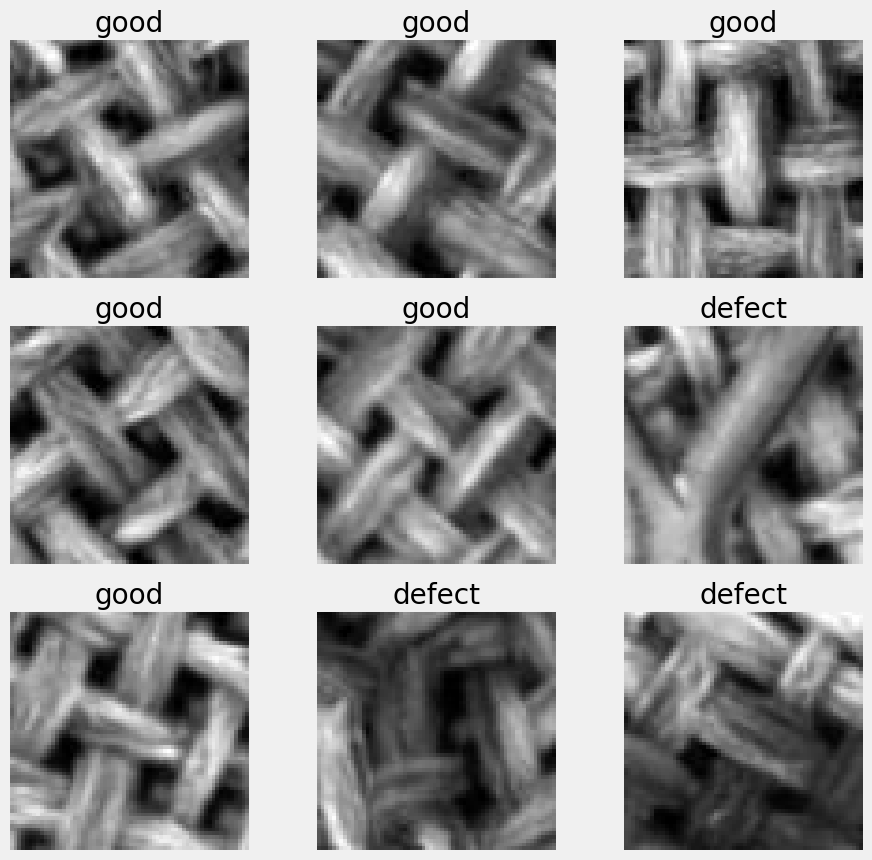

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(256, 64, 64, 3)
(256,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Preparing model for training

In [ ]:
num_classes = len(label_to_class_mapping)
num_classes

2

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.regularizers import l2

def create_model(input_shape=(60, 60, 3), num_classes=2, l2_reg=0.001):
    """
    Creates a custom CNN model with ResNet blocks for image classification.

    Args:
        input_shape: Shape of input images (height, width, channels)
        num_classes: Number of output classes
        l2_reg: L2 regularization factor

    Returns:
        A Keras Model object
    """
    # Input layer
    inputs = layers.Input(shape=input_shape)

    # Normalize inputs
    # x = layers.Rescaling(1./255)(inputs)

    # A. Initial Convolutional Layers
    x = layers.Conv2D(32, 3, strides=2, kernel_initializer='he_normal',
                     kernel_regularizer=l2(l2_reg), activation='relu')(x)
    x = layers.Conv2D(32, 5, padding='same', kernel_initializer='he_normal',
                     kernel_regularizer=l2(l2_reg), activation='relu')(x)

    # B. Large Features Extracting Block
    # First ResNet block
    shortcut = x
    x = layers.Conv2D(32, 5, padding='same', kernel_initializer='he_normal',
                     kernel_regularizer=l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(32, 5, padding='same', kernel_initializer='he_normal',
                     kernel_regularizer=l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Add()([shortcut, x])

    # Downsampling
    x = layers.Conv2D(32, 5, strides=2, padding='same', kernel_initializer='he_normal',
                     kernel_regularizer=l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Second ResNet block
    shortcut = x
    x = layers.Conv2D(64, 5, padding='same', kernel_initializer='he_normal',
                     kernel_regularizer=l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, 5, padding='same', kernel_initializer='he_normal',
                     kernel_regularizer=l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Adjust shortcut dimensions to match x for addition (if needed)
    shortcut = layers.Conv2D(64, 1, padding='same', kernel_initializer='he_normal',
                            kernel_regularizer=l2(l2_reg))(shortcut)
    shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([shortcut, x])

    # Downsampling
    x = layers.Conv2D(128, 5, strides=2, padding='same', kernel_initializer='he_normal',
                     kernel_regularizer=l2(l2_reg), activation='relu')(x)

    # C. Small Features Extracting Block
    # First ResNet block
    shortcut = x
    x = layers.Conv2D(32, 3, padding='same', kernel_initializer='he_normal',
                     kernel_regularizer=l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(32, 3, padding='same', kernel_initializer='he_normal',
                     kernel_regularizer=l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Adjust shortcut dimensions to match x for addition
    shortcut = layers.Conv2D(32, 1, padding='same', kernel_initializer='he_normal',
                            kernel_regularizer=l2(l2_reg))(shortcut)
    shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([shortcut, x])

    # Downsampling
    x = layers.Conv2D(32, 3, strides=2, padding='same', kernel_initializer='he_normal',
                     kernel_regularizer=l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Second ResNet block
    shortcut = x
    x = layers.Conv2D(64, 3, padding='same', kernel_initializer='he_normal',
                     kernel_regularizer=l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, 3, padding='same', kernel_initializer='he_normal',
                     kernel_regularizer=l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Adjust shortcut dimensions to match x for addition (if needed)
    shortcut = layers.Conv2D(64, 1, padding='same', kernel_initializer='he_normal',
                            kernel_regularizer=l2(l2_reg))(shortcut)
    shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([shortcut, x])

    # Final small features conv layer
    x = layers.Conv2D(128, 3, padding='same', kernel_initializer='he_normal',
                     kernel_regularizer=l2(l2_reg), activation='relu')(x)

    # D. Final Convolutional Layers
    x = layers.Conv2D(64, 3, padding='same', kernel_initializer='he_normal',
                     kernel_regularizer=l2(l2_reg), activation='relu')(x)

    x = layers.Conv2D(32, 3, strides=2, padding='same', kernel_initializer='he_normal',
                     kernel_regularizer=l2(l2_reg), activation='relu')(x)

    x = layers.Conv2D(16, 3, padding='same', kernel_initializer='he_normal',
                     kernel_regularizer=l2(l2_reg), activation='relu')(x)

    # Adjusted strides to account for smaller input size (60x60 vs 256x256)
    x = layers.Conv2D(8, 3, strides=2, padding='same', kernel_initializer='he_normal',
                     kernel_regularizer=l2(l2_reg), activation='relu')(x)

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Using softmax activation instead of sigmoid
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs, name="CustomCNN")
    return model

In [ ]:
model = create_model(input_shape=(img_size[0], img_size[1], 3), num_classes=num_classes)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

UnboundLocalError: cannot access local variable 'x' where it is not associated with a value

In [ ]:
with open("model_summary.txt", "w") as f:
    model.summary(print_fn=lambda x: f.write(x + "\n"))
model.summary()

Model: "CustomCNN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 64, 64, 3) │          0 │ input_layer[0][0] │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 31, 31,    │        896 │ rescaling[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 31, 31,    │     25,632 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 31, 31,    │     25,632 │ conv2d_1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 31, 31,    │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 31, 31,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 31, 31,    │     25,632 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 31,    │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 31, 31,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 31, 31,    │          0 │ conv2d_1[0][0],   │
│                     │ 32)               │            │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 16,    │     25,632 │ add[0][0]         │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 16, 16,    │     51,264 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 16, 16,    │          0 │ batch_normalizat

 Total params: 2,264,352 (8.64 MB)

 Trainable params: 754,378 (2.88 MB)

 Non-trainable params: 1,216 (4.75 KB)

 Optimizer params: 1,508,758 (5.76 MB)

In [ ]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  # <-- FIXED
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
    ]
)

In [ ]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=best_model_ckpt_path,
    save_weights_only=False,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

csv_logger_callback = tf.keras.callbacks.CSVLogger(
    filename='training_log.csv',
    separator=',',
    append=False
)

## Start training and validating results

In [ ]:
n_epoch = 100

In [ ]:
print('Results for CNN Classifier:-\n')
start_time = time.time()

result = model.fit(train_ds,
                   validation_data=val_ds,
                   class_weight=class_weights,
                   epochs=n_epoch,
                   callbacks=[checkpoint_callback, csv_logger_callback])

model_time = (time.time() - start_time)
print('\nTraining time(sec) = ', model_time)

Results for CNN Classifier:-

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8355 - loss: 0.8780
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to fabric_best_model.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.8346 - loss: 0.8638 - val_accuracy: 0.5000 - val_loss: 285.9579
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8668 - loss: 0.4031
Epoch 2: val_accuracy did not improve from 0.50000
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 0.8682 - loss: 0.4003 - val_accuracy: 0.5000 - val_loss: 1225.6970
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8911 - loss: 0.3371
Epoch 3: val_accuracy did not improve from 0.50000
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.8916 - loss: 0.3362 - val_accuracy: 0.5000 - val_loss: 3744.4080
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9232 - loss: 0.2917
Epoch 4: val_accuracy did not improve from 0.50000
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - 

In [ ]:
result.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

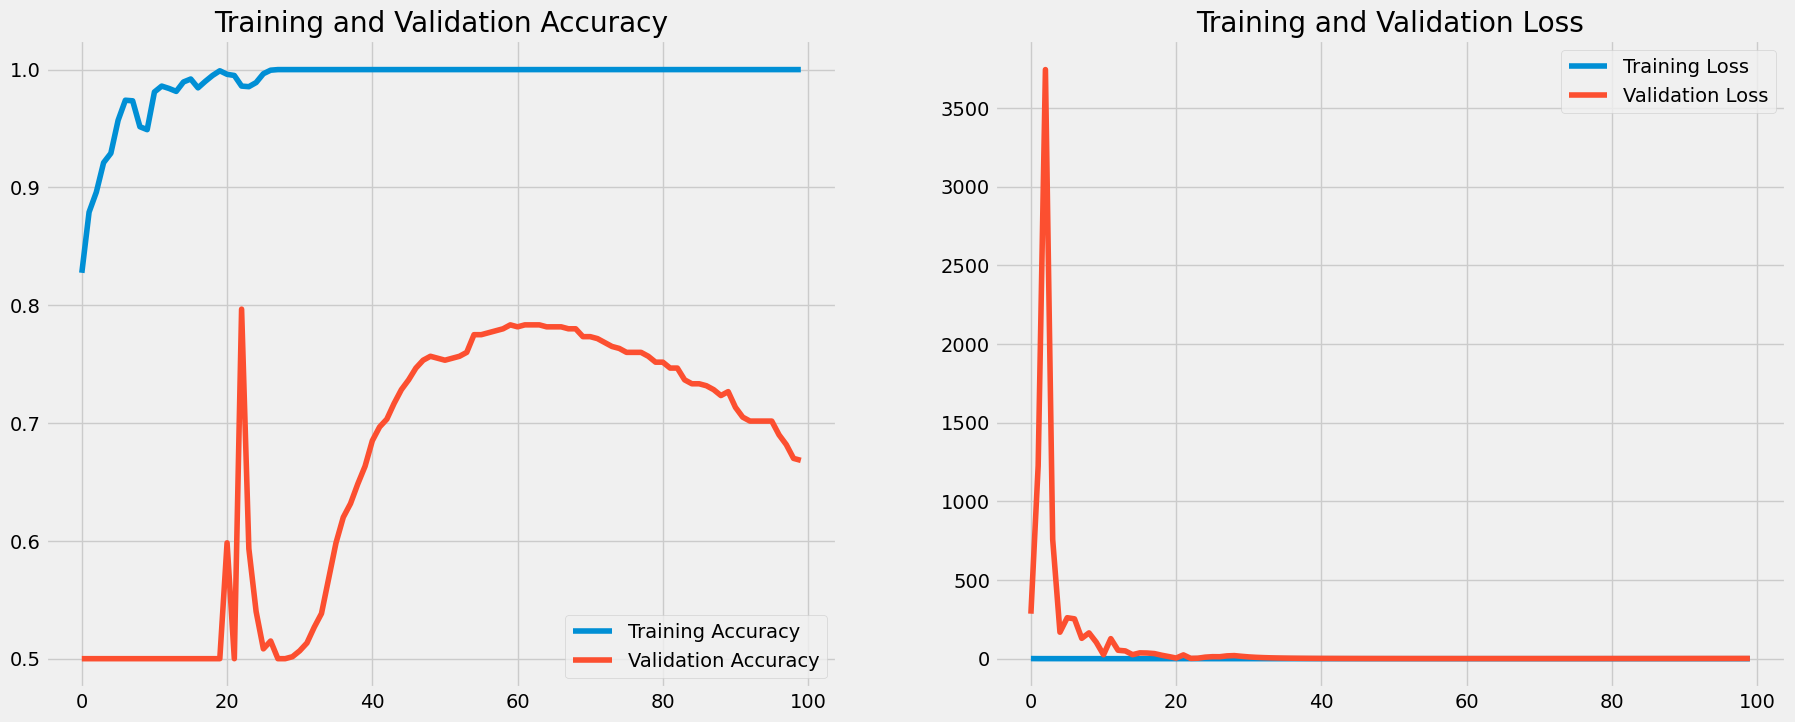

In [ ]:
acc = result.history['accuracy']
val_acc = result.history['val_accuracy']

loss = result.history['loss']
val_loss = result.history['val_loss']

epochs_range = range(n_epoch)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Testing and Evaluation

In [ ]:
model = tf.keras.models.load_model(best_model_ckpt_path)
model

<Functional name=CustomCNN, built=True>

In [ ]:
# Evaluate
train_score = model.evaluate(train_ds, verbose=1)
test_score = model.evaluate(val_ds, verbose=1)

# Create DataFrame
results_df = pd.DataFrame({
    'Dataset': ['Train', 'Test'],
    'Loss': [train_score[0], test_score[0]],
    'Accuracy': [train_score[1], test_score[1]]
})

# Round values for readability
results_df = results_df.round(3)
results_df.to_csv("results.csv",index=False)
results_df

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 221ms/step - accuracy: 0.8663 - loss: 0.8550
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 931ms/step - accuracy: 0.8051 - loss: 1.9039


,Dataset,Loss,Accuracy
0,Train,0.983,0.855
1,Test,1.996,0.797


In [ ]:
label_to_class_mapping

{0: 'defect', 1: 'good'}

1/3 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 565ms/step


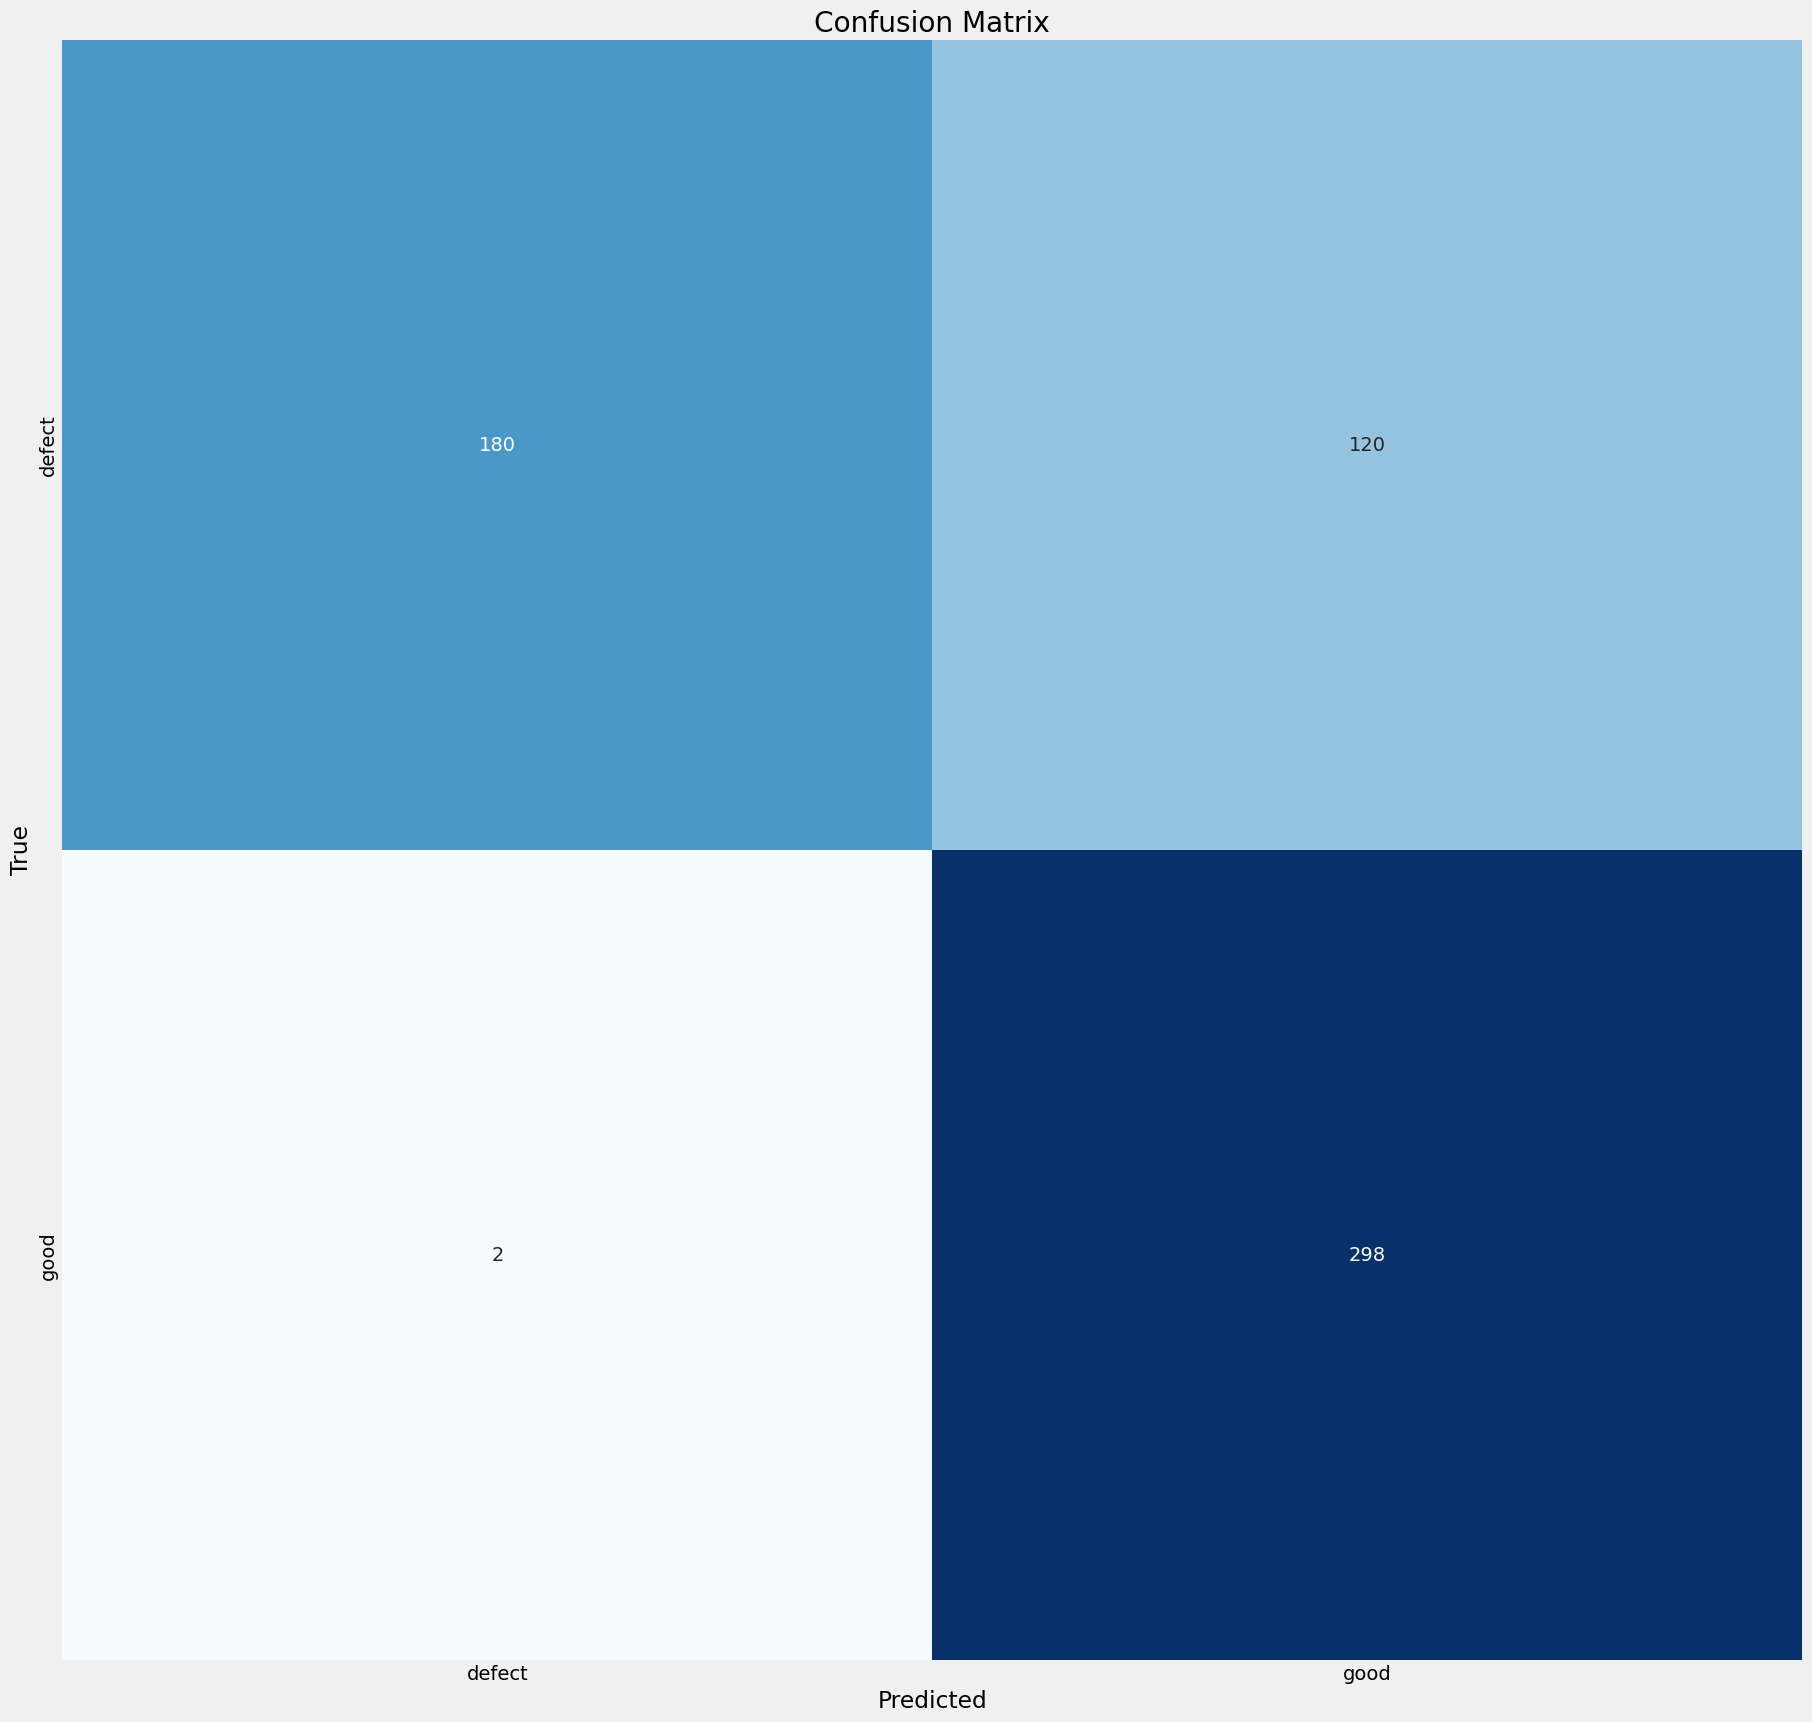

In [ ]:
# Make predictions
y_pred = model.predict(val_ds, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert logits to class indices

# Get true labels
y_true = np.array([y.numpy() for x, y in val_ds.unbatch()])
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
labels = list(label_to_class_mapping.values())
# Plot confusion matrix
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig("confusion_matrix.png")
plt.show()

In [ ]:
# Generate classification report
clr = classification_report(y_true, y_pred_classes, target_names=labels)
print(clr)

# Save to a text file
with open("classification_report.txt", "w") as f:
    f.write(clr)

              precision    recall  f1-score   support

      defect       0.99      0.60      0.75       300
        good       0.71      0.99      0.83       300

    accuracy                           0.80       600
   macro avg       0.85      0.80      0.79       600
weighted avg       0.85      0.80      0.79       600



## Live testing

In [ ]:
def get_model_size(path):
        size = os.path.getsize(path)
        if size < 1024:
            return f"{size} bytes"
        elif size < pow(1024,2):
            return f"{round(size/1024, 2)} KB"
        elif size < pow(1024,3):
            return f"{round(size/(pow(1024,2)), 2)} MB"
        elif size < pow(1024,4):
            return f"{round(size/(pow(1024,3)), 2)} GB"

In [ ]:
model = tf.keras.models.load_model(best_model_ckpt_path)
get_model_size(best_model_ckpt_path)

'8.88 MB'

In [ ]:
img_size

(64, 64)

In [ ]:
label_to_class_mapping

{0: 'defect', 1: 'good'}

In [ ]:
def predict_class(img_path):
    img = Image.open(img_path)
    resized_img = img.resize(img_size).convert("RGB")
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    # img = img / 255
    prob = model.predict(img)[0]
    return round(float(np.max(prob)),2), label_to_class_mapping[np.argmax(prob)]

def plot_results(img_path):
    img = Image.open(img_path).convert("RGB")
    resized_img = img.resize(img_size)
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    # img = img / 255
    prob = model.predict(img)
    prob = [round(float(i), 5) for i in prob[0]]

    # Sort probabilities and labels based on probability
    sorted_probs, sorted_labels = zip(*sorted(zip(prob, list(label_to_class_mapping.values())), reverse=False))

    # Create a larger plot
    plt.figure(figsize=(10, 8))

    # Plot the image
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.axis('off')  # Hide axes for the image

    # Plot the probabilities
    plt.subplot(2, 1, 2)
    bars = plt.barh(sorted_labels, sorted_probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt='%.5f')

    plt.tight_layout()  # To avoid overlapping subplots
    plt.show()

In [ ]:
sample_data = test_df.drop_duplicates('Class')
sample_data

,Image Path,Class
0,/content/data/test/defect/d59022a5-88f7-40a4-8...,defect
300,/content/data/test/good/ebbcdd3c-21a7-4d70-8df...,good


In [ ]:
prob,pred = predict_class(sample_data['Image Path'].values[0])
prob,pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


(0.9, 'defect')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


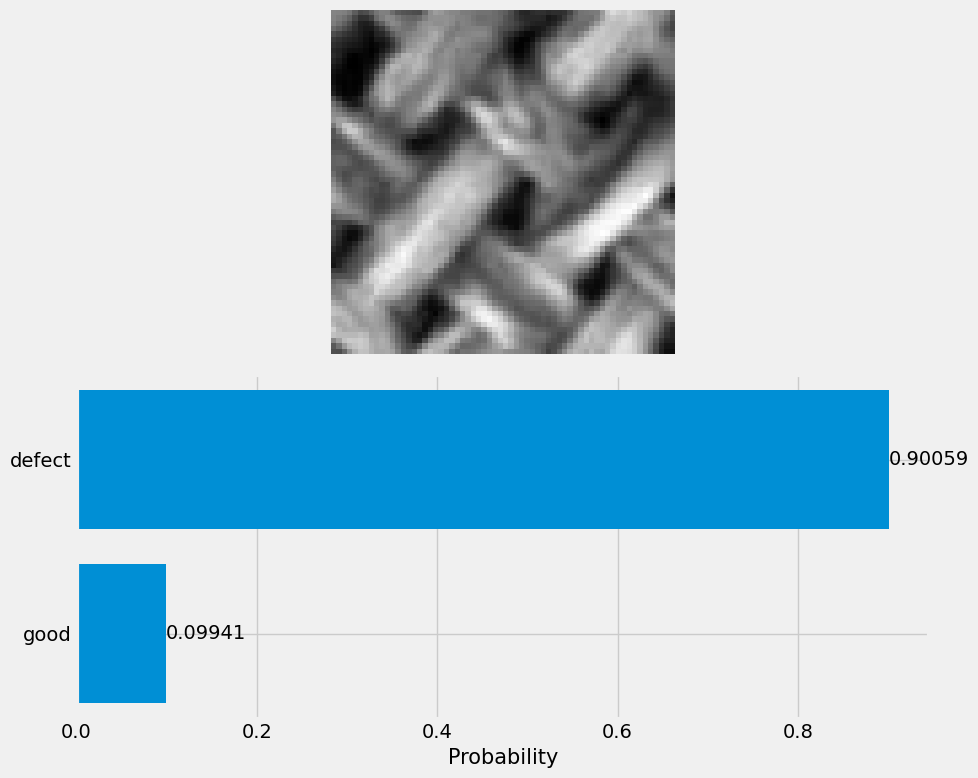

In [ ]:
plot_results(sample_data['Image Path'].values[0])

In [ ]:
prob,pred = predict_class(sample_data['Image Path'].values[1])
prob,pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


(0.9, 'defect')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


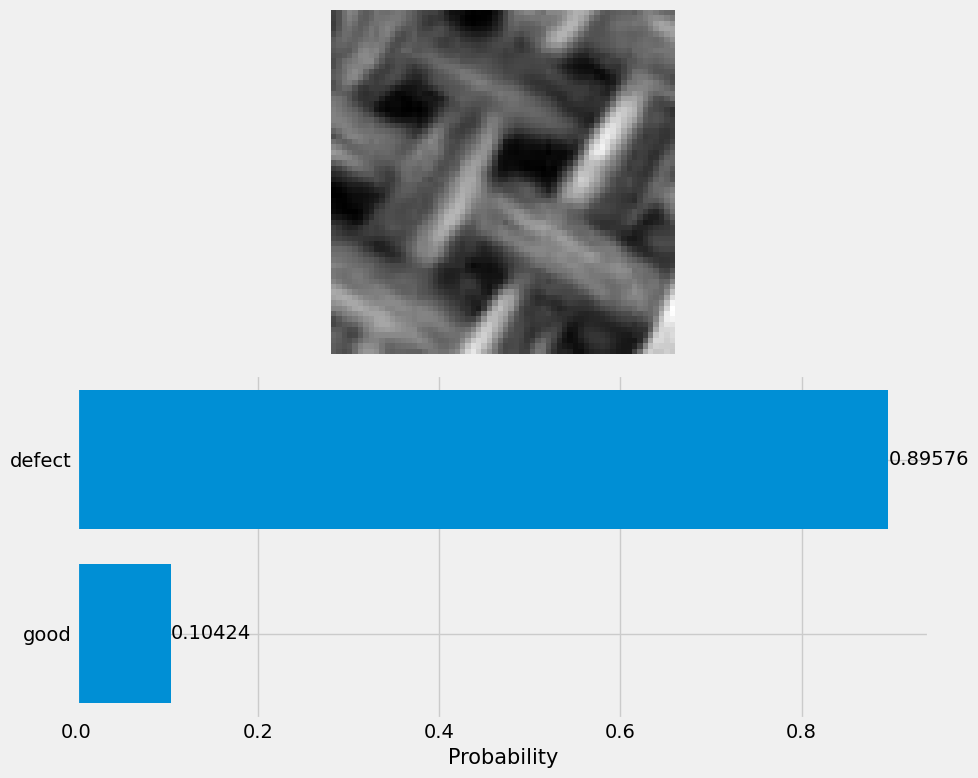

In [ ]:
plot_results(sample_data['Image Path'].values[1])

In [ ]:
train_df.head()

,Image Path,Class
0,/content/data/train/defect/1ff4ea92-e8b1-468e-...,defect
1,/content/data/train/defect/aug_0a379773-2075-4...,defect
2,/content/data/train/defect/cb8a85fc-28ac-43aa-...,defect
3,/content/data/train/defect/aug_8db8609c-046b-4...,defect
4,/content/data/train/defect/aug_ae97a717-aa4d-4...,defect


In [ ]:
# !rm -rf /content/results_data

In [ ]:
# # Set the threshold for maximum number of images per class
# threshold = 10  # Change this to the desired threshold
# sample_data_path = 'sample_images'
# os.makedirs(sample_data_path, exist_ok=True)

# # Dictionary to keep track of the number of images copied for each class
# class_counts = {}

# # Iterate through each row and save correctly predicted images
# for idx, row in tqdm(train_df.iterrows(), total=len(train_df)):
#     img_path = row['Image Path']
#     true_label = row['Class']
#     confidence, pred_label = predict_class(img_path)

#     if pred_label == true_label:
#         # Check if the class has already reached the threshold
#         if class_counts.get(pred_label, 0) >= threshold:
#             continue  # Skip if the threshold is reached

#         class_folder = os.path.join(sample_data_path, pred_label)
#         os.makedirs(class_folder, exist_ok=True)

#         # Copy the image to the respective folder
#         shutil.copy(img_path, class_folder)

#         # Increment the count for the class
#         class_counts[pred_label] = class_counts.get(pred_label, 0) + 1

  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 1/2000 [00:00<04:20,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


  0%|          | 2/2000 [00:00<04:55,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


  0%|          | 3/2000 [00:00<06:07,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


  0%|          | 4/2000 [00:00<05:34,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 5/2000 [00:00<05:40,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


  0%|          | 6/2000 [00:00<05:35,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


  0%|          | 7/2000 [00:01<05:50,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


  0%|          | 8/2000 [00:01<05:44,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 10/2000 [00:01<03:59,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  1%|          | 12/2000 [00:01<03:16, 10.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  1%|          | 14/2000 [00:01<02:51, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  1%|          | 16/2000 [00:01<02:37, 12.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  1%|          | 18/2000 [00:02<02:34, 12.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  1%|          | 20/2000 [00:02<02:24, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  1%|          | 22/2000 [00:02<02:22, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  1%|          | 24/2000 [00:02<02:16, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  1%|▏         | 26/2000 [00:02<02:13, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  1%|▏         | 28/2000 [00:02<02:24, 13.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  2%|▏         | 30/2000 [00:02<02:20, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  2%|▏         | 32/2000 [00:02<02:16, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  2%|▏         | 34/2000 [00:03<02:12, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  2%|▏         | 36/2000 [00:03<02:08, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  2%|▏         | 38/2000 [00:03<02:19, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  2%|▏         | 40/2000 [00:03<02:15, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  2%|▏         | 42/2000 [00:03<02:11, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  2%|▏         | 44/2000 [00:03<02:22, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  2%|▏         | 46/2000 [00:03<02:17, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


  2%|▏         | 48/2000 [00:04<03:36,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


  2%|▎         | 50/2000 [00:04<03:49,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


  3%|▎         | 52/2000 [00:05<04:37,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


  3%|▎         | 53/2000 [00:05<05:07,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


  3%|▎         | 54/2000 [00:05<05:40,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


  3%|▎         | 55/2000 [00:05<06:29,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


  3%|▎         | 56/2000 [00:06<06:46,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


  3%|▎         | 57/2000 [00:06<07:19,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


  3%|▎         | 58/2000 [00:06<08:20,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


  3%|▎         | 59/2000 [00:06<07:19,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


  3%|▎         | 60/2000 [00:07<08:10,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


  3%|▎         | 61/2000 [00:07<08:16,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


  3%|▎         | 62/2000 [00:07<07:46,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


  3%|▎         | 63/2000 [00:07<08:54,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


  3%|▎         | 64/2000 [00:08<08:34,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


  3%|▎         | 65/2000 [00:08<08:37,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  3%|▎         | 66/2000 [00:08<09:44,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


  3%|▎         | 67/2000 [00:09<08:59,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


  3%|▎         | 68/2000 [00:09<08:41,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  3%|▎         | 69/2000 [00:09<07:09,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  4%|▎         | 70/2000 [00:09<06:11,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


  4%|▎         | 71/2000 [00:09<06:45,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


  4%|▎         | 72/2000 [00:09<06:28,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


  4%|▎         | 73/2000 [00:10<06:10,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  4%|▎         | 74/2000 [00:10<05:45,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


  4%|▍         | 75/2000 [00:10<06:13,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  4%|▍         | 76/2000 [00:10<05:47,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


  4%|▍         | 77/2000 [00:10<06:03,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  4%|▍         | 78/2000 [00:11<06:28,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  4%|▍         | 79/2000 [00:11<07:09,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


  4%|▍         | 80/2000 [00:11<07:21,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


  4%|▍         | 81/2000 [00:11<06:53,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


  4%|▍         | 82/2000 [00:12<06:43,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  4%|▍         | 84/2000 [00:12<04:33,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  4%|▍         | 86/2000 [00:12<03:53,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  4%|▍         | 87/2000 [00:12<03:59,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


  4%|▍         | 88/2000 [00:12<04:01,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


  4%|▍         | 89/2000 [00:12<05:04,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  4%|▍         | 90/2000 [00:12<04:44,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  5%|▍         | 91/2000 [00:13<04:38,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


  5%|▍         | 92/2000 [00:13<04:36,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  5%|▍         | 93/2000 [00:13<04:36,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  5%|▍         | 94/2000 [00:13<04:27,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  5%|▍         | 95/2000 [00:13<04:05,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  5%|▍         | 96/2000 [00:13<04:07,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


  5%|▍         | 97/2000 [00:13<04:16,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


  5%|▍         | 98/2000 [00:14<04:23,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  5%|▍         | 99/2000 [00:14<04:22,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  5%|▌         | 100/2000 [00:14<04:26,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


  5%|▌         | 101/2000 [00:14<04:50,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  5%|▌         | 102/2000 [00:14<04:37,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  5%|▌         | 103/2000 [00:14<04:15,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  5%|▌         | 104/2000 [00:14<04:36,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  5%|▌         | 106/2000 [00:15<03:46,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  5%|▌         | 107/2000 [00:15<03:52,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  5%|▌         | 108/2000 [00:15<04:03,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  5%|▌         | 109/2000 [00:15<04:03,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


  6%|▌         | 110/2000 [00:15<03:57,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  6%|▌         | 111/2000 [00:15<03:49,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  6%|▌         | 112/2000 [00:15<03:52,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


  6%|▌         | 113/2000 [00:15<03:52,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  6%|▌         | 114/2000 [00:16<03:58,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  6%|▌         | 115/2000 [00:16<04:00,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  6%|▌         | 116/2000 [00:16<04:02,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  6%|▌         | 117/2000 [00:16<04:03,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  6%|▌         | 118/2000 [00:16<04:05,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  6%|▌         | 119/2000 [00:16<04:10,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  6%|▌         | 120/2000 [00:16<04:11,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


  6%|▌         | 121/2000 [00:17<04:45,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  6%|▌         | 123/2000 [00:17<04:04,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


  6%|▌         | 124/2000 [00:17<05:07,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


  6%|▋         | 125/2000 [00:17<06:20,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  6%|▋         | 126/2000 [00:18<05:31,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


  6%|▋         | 127/2000 [00:18<04:52,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  6%|▋         | 129/2000 [00:18<03:36,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  7%|▋         | 131/2000 [00:18<02:58, 10.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  7%|▋         | 133/2000 [00:18<02:35, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  7%|▋         | 135/2000 [00:18<02:23, 12.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  7%|▋         | 137/2000 [00:18<02:15, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  7%|▋         | 139/2000 [00:18<02:10, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  7%|▋         | 141/2000 [00:19<02:33, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  7%|▋         | 143/2000 [00:19<02:58, 10.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  7%|▋         | 145/2000 [00:19<02:53, 10.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  7%|▋         | 147/2000 [00:19<03:02, 10.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  7%|▋         | 149/2000 [00:19<02:57, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  8%|▊         | 151/2000 [00:20<03:01, 10.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  8%|▊         | 153/2000 [00:20<03:24,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  8%|▊         | 155/2000 [00:20<03:22,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  8%|▊         | 156/2000 [00:20<03:25,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  8%|▊         | 158/2000 [00:20<03:11,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  8%|▊         | 159/2000 [00:21<03:20,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  8%|▊         | 160/2000 [00:21<03:28,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


  8%|▊         | 161/2000 [00:21<03:41,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  8%|▊         | 162/2000 [00:21<03:44,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  8%|▊         | 163/2000 [00:21<03:49,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  8%|▊         | 164/2000 [00:21<03:52,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  8%|▊         | 165/2000 [00:21<03:54,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  8%|▊         | 167/2000 [00:22<03:18,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  8%|▊         | 168/2000 [00:22<03:17,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  8%|▊         | 170/2000 [00:22<02:44, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  9%|▊         | 172/2000 [00:22<02:34, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  9%|▊         | 174/2000 [00:22<02:21, 12.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  9%|▉         | 176/2000 [00:22<02:12, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  9%|▉         | 178/2000 [00:22<02:08, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  9%|▉         | 180/2000 [00:22<02:04, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  9%|▉         | 182/2000 [00:23<02:03, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  9%|▉         | 184/2000 [00:23<02:01, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  9%|▉         | 186/2000 [00:23<02:15, 13.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  9%|▉         | 188/2000 [00:23<02:09, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 10%|▉         | 190/2000 [00:23<02:06, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 10%|▉         | 192/2000 [00:23<02:25, 12.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 10%|▉         | 194/2000 [00:23<02:16, 13.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 10%|▉         | 196/2000 [00:24<02:13, 13.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 10%|▉         | 198/2000 [00:24<02:08, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 10%|█         | 200/2000 [00:24<02:16, 13.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 10%|█         | 202/2000 [00:24<02:11, 13.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 10%|█         | 204/2000 [00:24<02:07, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 10%|█         | 206/2000 [00:24<02:04, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 10%|█         | 208/2000 [00:24<02:03, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 10%|█         | 210/2000 [00:25<02:01, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 11%|█         | 212/2000 [00:25<01:58, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 11%|█         | 214/2000 [00:25<01:57, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 11%|█         | 216/2000 [00:25<02:17, 12.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 11%|█         | 218/2000 [00:25<02:11, 13.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 11%|█         | 220/2000 [00:25<02:08, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 11%|█         | 222/2000 [00:25<02:03, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 11%|█         | 224/2000 [00:26<02:00, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 11%|█▏        | 226/2000 [00:26<01:57, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 11%|█▏        | 228/2000 [00:26<01:55, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 12%|█▏        | 230/2000 [00:26<02:05, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 12%|█▏        | 232/2000 [00:26<02:13, 13.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 12%|█▏        | 234/2000 [00:26<02:06, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 12%|█▏        | 236/2000 [00:26<02:03, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 12%|█▏        | 238/2000 [00:27<01:59, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 12%|█▏        | 240/2000 [00:27<01:57, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 12%|█▏        | 242/2000 [00:27<01:58, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 12%|█▏        | 244/2000 [00:27<02:14, 13.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 12%|█▏        | 246/2000 [00:27<02:09, 13.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 12%|█▏        | 248/2000 [00:27<02:04, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 12%|█▎        | 250/2000 [00:27<02:01, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 13%|█▎        | 252/2000 [00:28<01:59, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 13%|█▎        | 254/2000 [00:28<01:57, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 13%|█▎        | 256/2000 [00:28<01:56, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 13%|█▎        | 258/2000 [00:28<01:55, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 13%|█▎        | 260/2000 [00:28<01:57, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 13%|█▎        | 262/2000 [00:28<01:56, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 13%|█▎        | 264/2000 [00:28<01:54, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 13%|█▎        | 266/2000 [00:28<01:53, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 13%|█▎        | 268/2000 [00:29<01:54, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 14%|█▎        | 270/2000 [00:29<01:53, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 14%|█▎        | 272/2000 [00:29<01:52, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 14%|█▎        | 274/2000 [00:29<01:52, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 14%|█▍        | 276/2000 [00:29<02:01, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 14%|█▍        | 278/2000 [00:29<01:58, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 14%|█▍        | 280/2000 [00:29<01:58, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 14%|█▍        | 282/2000 [00:30<02:06, 13.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 14%|█▍        | 284/2000 [00:30<02:01, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 14%|█▍        | 286/2000 [00:30<02:08, 13.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 14%|█▍        | 288/2000 [00:30<02:03, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 14%|█▍        | 290/2000 [00:30<02:11, 13.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 15%|█▍        | 292/2000 [00:30<02:17, 12.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 15%|█▍        | 294/2000 [00:31<02:19, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 15%|█▍        | 296/2000 [00:31<02:11, 12.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 15%|█▍        | 298/2000 [00:31<02:03, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 15%|█▌        | 300/2000 [00:31<01:59, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 15%|█▌        | 302/2000 [00:31<01:56, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 15%|█▌        | 304/2000 [00:31<02:01, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 15%|█▌        | 306/2000 [00:31<01:57, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 15%|█▌        | 308/2000 [00:32<02:25, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 16%|█▌        | 310/2000 [00:32<02:43, 10.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 16%|█▌        | 312/2000 [00:32<02:55,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 16%|█▌        | 314/2000 [00:32<03:02,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 16%|█▌        | 316/2000 [00:33<03:02,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 16%|█▌        | 318/2000 [00:33<02:55,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 16%|█▌        | 320/2000 [00:33<02:49,  9.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 16%|█▌        | 322/2000 [00:33<02:41, 10.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 16%|█▌        | 324/2000 [00:33<02:47, 10.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 16%|█▋        | 326/2000 [00:33<02:40, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 16%|█▋        | 328/2000 [00:34<02:56,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 16%|█▋        | 329/2000 [00:34<03:05,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 17%|█▋        | 331/2000 [00:34<03:09,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 17%|█▋        | 332/2000 [00:34<03:15,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 17%|█▋        | 333/2000 [00:34<03:18,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 17%|█▋        | 334/2000 [00:34<03:11,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 17%|█▋        | 336/2000 [00:35<02:39, 10.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 17%|█▋        | 338/2000 [00:35<02:19, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 17%|█▋        | 340/2000 [00:35<02:10, 12.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 17%|█▋        | 342/2000 [00:35<02:13, 12.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 17%|█▋        | 344/2000 [00:35<02:16, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 17%|█▋        | 346/2000 [00:35<02:19, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 17%|█▋        | 348/2000 [00:35<02:10, 12.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 18%|█▊        | 350/2000 [00:36<02:13, 12.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 18%|█▊        | 352/2000 [00:36<02:17, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 18%|█▊        | 354/2000 [00:36<02:19, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 18%|█▊        | 356/2000 [00:36<02:21, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 18%|█▊        | 358/2000 [00:36<02:33, 10.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 18%|█▊        | 360/2000 [00:37<02:19, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 18%|█▊        | 362/2000 [00:37<02:19, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 18%|█▊        | 364/2000 [00:37<02:21, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 18%|█▊        | 366/2000 [00:37<02:15, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 18%|█▊        | 368/2000 [00:37<02:28, 11.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 18%|█▊        | 370/2000 [00:37<02:19, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 19%|█▊        | 372/2000 [00:38<02:21, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 19%|█▊        | 374/2000 [00:38<02:11, 12.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 19%|█▉        | 376/2000 [00:38<02:06, 12.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 19%|█▉        | 378/2000 [00:38<02:11, 12.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 19%|█▉        | 380/2000 [00:38<02:14, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 19%|█▉        | 382/2000 [00:38<02:18, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 19%|█▉        | 384/2000 [00:39<02:28, 10.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 19%|█▉        | 386/2000 [00:39<02:15, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 19%|█▉        | 388/2000 [00:39<02:17, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 20%|█▉        | 390/2000 [00:39<02:09, 12.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 20%|█▉        | 392/2000 [00:39<02:23, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 20%|█▉        | 394/2000 [00:39<02:20, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 20%|█▉        | 396/2000 [00:40<02:30, 10.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 20%|█▉        | 398/2000 [00:40<02:18, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 20%|██        | 400/2000 [00:40<02:31, 10.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 20%|██        | 402/2000 [00:40<02:38, 10.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 20%|██        | 404/2000 [00:40<02:25, 10.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 20%|██        | 406/2000 [00:41<02:26, 10.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 20%|██        | 408/2000 [00:41<02:24, 11.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 20%|██        | 410/2000 [00:41<02:31, 10.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 21%|██        | 412/2000 [00:41<02:39,  9.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 21%|██        | 414/2000 [00:41<02:33, 10.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 21%|██        | 416/2000 [00:42<02:29, 10.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 21%|██        | 418/2000 [00:42<02:26, 10.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 21%|██        | 420/2000 [00:42<02:14, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 21%|██        | 422/2000 [00:42<02:05, 12.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 21%|██        | 424/2000 [00:42<02:11, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 21%|██▏       | 426/2000 [00:42<02:22, 11.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 21%|██▏       | 428/2000 [00:43<02:31, 10.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 22%|██▏       | 430/2000 [00:43<02:26, 10.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 22%|██▏       | 432/2000 [00:43<02:32, 10.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 22%|██▏       | 434/2000 [00:43<02:19, 11.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 22%|██▏       | 436/2000 [00:43<02:29, 10.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 22%|██▏       | 438/2000 [00:44<02:26, 10.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 22%|██▏       | 440/2000 [00:44<02:32, 10.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 22%|██▏       | 442/2000 [00:44<02:36,  9.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 22%|██▏       | 444/2000 [00:44<02:20, 11.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 22%|██▏       | 446/2000 [00:44<02:27, 10.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 22%|██▏       | 448/2000 [00:45<02:46,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 22%|██▏       | 449/2000 [00:45<02:47,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 22%|██▎       | 450/2000 [00:45<02:53,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 23%|██▎       | 451/2000 [00:45<02:49,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 23%|██▎       | 452/2000 [00:45<02:57,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 23%|██▎       | 453/2000 [00:45<02:55,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 23%|██▎       | 455/2000 [00:45<02:50,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 23%|██▎       | 456/2000 [00:46<02:57,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 23%|██▎       | 457/2000 [00:46<02:58,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 23%|██▎       | 459/2000 [00:46<02:42,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 23%|██▎       | 461/2000 [00:46<02:44,  9.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 23%|██▎       | 462/2000 [00:46<02:44,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 23%|██▎       | 463/2000 [00:46<02:57,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 23%|██▎       | 464/2000 [00:46<02:53,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 23%|██▎       | 466/2000 [00:47<02:51,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 23%|██▎       | 467/2000 [00:47<03:00,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 23%|██▎       | 468/2000 [00:47<03:05,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 23%|██▎       | 469/2000 [00:47<03:07,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 24%|██▎       | 470/2000 [00:47<03:12,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 24%|██▎       | 471/2000 [00:47<03:05,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 24%|██▎       | 472/2000 [00:47<03:12,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 24%|██▎       | 473/2000 [00:48<03:15,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 24%|██▎       | 474/2000 [00:48<03:13,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 24%|██▍       | 475/2000 [00:48<03:13,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 24%|██▍       | 477/2000 [00:48<02:47,  9.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 24%|██▍       | 478/2000 [00:48<02:49,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 24%|██▍       | 480/2000 [00:48<02:35,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 24%|██▍       | 482/2000 [00:48<02:15, 11.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 24%|██▍       | 484/2000 [00:49<02:17, 11.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 24%|██▍       | 486/2000 [00:49<02:06, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 24%|██▍       | 488/2000 [00:49<02:11, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 24%|██▍       | 490/2000 [00:49<02:11, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 25%|██▍       | 492/2000 [00:49<02:11, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 25%|██▍       | 494/2000 [00:49<02:21, 10.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 25%|██▍       | 496/2000 [00:50<02:30, 10.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 25%|██▍       | 498/2000 [00:50<02:29, 10.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 25%|██▌       | 500/2000 [00:50<02:25, 10.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 25%|██▌       | 502/2000 [00:50<02:21, 10.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 25%|██▌       | 504/2000 [00:50<02:18, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 25%|██▌       | 506/2000 [00:51<02:06, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 25%|██▌       | 508/2000 [00:51<02:09, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 26%|██▌       | 510/2000 [00:51<02:13, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 26%|██▌       | 512/2000 [00:51<02:04, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 26%|██▌       | 514/2000 [00:51<02:15, 10.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 26%|██▌       | 516/2000 [00:51<02:13, 11.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 26%|██▌       | 518/2000 [00:52<02:13, 11.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 26%|██▌       | 520/2000 [00:52<02:23, 10.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 26%|██▌       | 522/2000 [00:52<02:24, 10.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 26%|██▌       | 524/2000 [00:52<02:29,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 26%|██▋       | 526/2000 [00:52<02:25, 10.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 26%|██▋       | 528/2000 [00:53<02:11, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 26%|██▋       | 530/2000 [00:53<02:10, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 27%|██▋       | 532/2000 [00:53<02:22, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 27%|██▋       | 534/2000 [00:53<02:19, 10.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 27%|██▋       | 536/2000 [00:53<02:27,  9.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 27%|██▋       | 538/2000 [00:54<02:21, 10.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 27%|██▋       | 540/2000 [00:54<02:18, 10.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 27%|██▋       | 542/2000 [00:54<02:06, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 27%|██▋       | 544/2000 [00:54<02:20, 10.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 27%|██▋       | 546/2000 [00:54<02:17, 10.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 27%|██▋       | 548/2000 [00:55<02:15, 10.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 28%|██▊       | 550/2000 [00:55<02:13, 10.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 28%|██▊       | 552/2000 [00:55<02:20, 10.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 28%|██▊       | 554/2000 [00:55<02:16, 10.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 28%|██▊       | 556/2000 [00:55<02:16, 10.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 28%|██▊       | 558/2000 [00:55<02:05, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 28%|██▊       | 560/2000 [00:56<02:05, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 28%|██▊       | 562/2000 [00:56<01:56, 12.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 28%|██▊       | 564/2000 [00:56<01:49, 13.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 28%|██▊       | 566/2000 [00:56<01:44, 13.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 28%|██▊       | 568/2000 [00:56<02:01, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 28%|██▊       | 570/2000 [00:56<02:10, 10.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 29%|██▊       | 572/2000 [00:57<02:09, 11.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 29%|██▊       | 574/2000 [00:57<02:07, 11.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 29%|██▉       | 576/2000 [00:57<01:57, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 29%|██▉       | 578/2000 [00:57<01:59, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 29%|██▉       | 580/2000 [00:57<01:53, 12.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 29%|██▉       | 582/2000 [00:57<01:48, 13.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 29%|██▉       | 584/2000 [00:58<02:01, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 29%|██▉       | 586/2000 [00:58<01:54, 12.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 29%|██▉       | 588/2000 [00:58<02:11, 10.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 30%|██▉       | 590/2000 [00:58<02:24,  9.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 30%|██▉       | 592/2000 [00:58<02:32,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 30%|██▉       | 593/2000 [00:59<02:36,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 30%|██▉       | 594/2000 [00:59<02:42,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 30%|██▉       | 595/2000 [00:59<02:39,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 30%|██▉       | 596/2000 [00:59<02:44,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 30%|██▉       | 597/2000 [00:59<02:47,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 30%|██▉       | 598/2000 [00:59<02:58,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 30%|██▉       | 599/2000 [00:59<02:59,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 30%|███       | 600/2000 [00:59<03:00,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 30%|███       | 601/2000 [01:00<03:02,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 30%|███       | 602/2000 [01:00<03:01,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 30%|███       | 604/2000 [01:00<02:48,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 30%|███       | 605/2000 [01:00<02:54,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 30%|███       | 606/2000 [01:00<02:58,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 30%|███       | 607/2000 [01:00<03:00,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 30%|███       | 608/2000 [01:00<03:03,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 30%|███       | 609/2000 [01:01<03:05,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 30%|███       | 610/2000 [01:01<03:04,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 31%|███       | 612/2000 [01:01<02:24,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 31%|███       | 614/2000 [01:01<02:03, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 31%|███       | 616/2000 [01:01<02:04, 11.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 31%|███       | 618/2000 [01:01<02:05, 10.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 31%|███       | 620/2000 [01:02<01:56, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 31%|███       | 622/2000 [01:02<01:48, 12.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 31%|███       | 624/2000 [01:02<01:43, 13.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 31%|███▏      | 626/2000 [01:02<01:39, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 31%|███▏      | 628/2000 [01:02<01:46, 12.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 32%|███▏      | 630/2000 [01:02<02:00, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 32%|███▏      | 632/2000 [01:02<01:51, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 32%|███▏      | 634/2000 [01:03<01:53, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 32%|███▏      | 636/2000 [01:03<01:54, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 32%|███▏      | 638/2000 [01:03<01:46, 12.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 32%|███▏      | 640/2000 [01:03<01:51, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 32%|███▏      | 642/2000 [01:03<01:56, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 32%|███▏      | 644/2000 [01:04<02:05, 10.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 32%|███▏      | 646/2000 [01:04<01:55, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 32%|███▏      | 648/2000 [01:04<01:47, 12.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 32%|███▎      | 650/2000 [01:04<01:48, 12.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 33%|███▎      | 652/2000 [01:04<01:59, 11.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 33%|███▎      | 654/2000 [01:04<02:04, 10.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 33%|███▎      | 656/2000 [01:05<02:10, 10.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 33%|███▎      | 658/2000 [01:05<02:06, 10.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 33%|███▎      | 660/2000 [01:05<01:54, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 33%|███▎      | 662/2000 [01:05<01:54, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 33%|███▎      | 664/2000 [01:05<01:57, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 33%|███▎      | 666/2000 [01:05<02:00, 11.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 33%|███▎      | 668/2000 [01:06<01:52, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 34%|███▎      | 670/2000 [01:06<01:46, 12.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 34%|███▎      | 672/2000 [01:06<01:49, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 34%|███▎      | 674/2000 [01:06<01:50, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 34%|███▍      | 676/2000 [01:06<02:03, 10.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 34%|███▍      | 678/2000 [01:06<01:57, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 34%|███▍      | 680/2000 [01:07<01:57, 11.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 34%|███▍      | 682/2000 [01:07<01:56, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 34%|███▍      | 684/2000 [01:07<01:47, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 34%|███▍      | 686/2000 [01:07<01:48, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 34%|███▍      | 688/2000 [01:07<01:44, 12.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 34%|███▍      | 690/2000 [01:08<01:57, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 35%|███▍      | 692/2000 [01:08<01:49, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 35%|███▍      | 694/2000 [01:08<01:50, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 35%|███▍      | 696/2000 [01:08<01:50, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 35%|███▍      | 698/2000 [01:08<01:43, 12.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 35%|███▌      | 700/2000 [01:09<02:41,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 35%|███▌      | 702/2000 [01:09<02:20,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 35%|███▌      | 704/2000 [01:09<02:13,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 35%|███▌      | 706/2000 [01:09<02:03, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 35%|███▌      | 708/2000 [01:09<02:40,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 36%|███▌      | 710/2000 [01:10<02:21,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 36%|███▌      | 712/2000 [01:10<02:23,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 36%|███▌      | 714/2000 [01:10<02:47,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 36%|███▌      | 715/2000 [01:10<02:54,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 36%|███▌      | 716/2000 [01:10<02:48,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 36%|███▌      | 718/2000 [01:11<02:31,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 36%|███▌      | 719/2000 [01:11<02:28,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 36%|███▌      | 720/2000 [01:11<02:32,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 36%|███▌      | 721/2000 [01:11<02:27,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 36%|███▌      | 722/2000 [01:11<02:32,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 36%|███▌      | 723/2000 [01:11<02:37,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 36%|███▋      | 725/2000 [01:11<02:20,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 36%|███▋      | 726/2000 [01:12<02:25,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 36%|███▋      | 727/2000 [01:12<02:34,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 36%|███▋      | 728/2000 [01:12<02:37,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 36%|███▋      | 729/2000 [01:12<02:43,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 36%|███▋      | 730/2000 [01:12<02:34,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 37%|███▋      | 732/2000 [01:12<02:28,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 37%|███▋      | 733/2000 [01:12<02:34,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 37%|███▋      | 735/2000 [01:13<02:30,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 37%|███▋      | 736/2000 [01:13<02:30,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 37%|███▋      | 737/2000 [01:13<02:28,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 37%|███▋      | 738/2000 [01:13<02:33,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 37%|███▋      | 739/2000 [01:13<02:29,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 37%|███▋      | 740/2000 [01:13<02:35,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 37%|███▋      | 741/2000 [01:13<02:36,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 37%|███▋      | 742/2000 [01:14<02:39,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 37%|███▋      | 743/2000 [01:14<02:38,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 37%|███▋      | 744/2000 [01:14<02:43,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 37%|███▋      | 745/2000 [01:14<02:41,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 37%|███▋      | 746/2000 [01:14<02:42,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 37%|███▋      | 747/2000 [01:14<02:46,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 37%|███▋      | 749/2000 [01:14<02:24,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 38%|███▊      | 750/2000 [01:15<02:23,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 38%|███▊      | 752/2000 [01:15<02:14,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 38%|███▊      | 754/2000 [01:15<02:10,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 38%|███▊      | 756/2000 [01:15<02:04,  9.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 38%|███▊      | 757/2000 [01:15<02:08,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 38%|███▊      | 758/2000 [01:15<02:10,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 38%|███▊      | 759/2000 [01:15<02:13,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 38%|███▊      | 760/2000 [01:16<02:15,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 38%|███▊      | 761/2000 [01:16<02:16,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 38%|███▊      | 763/2000 [01:16<02:07,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 38%|███▊      | 764/2000 [01:16<02:11,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 38%|███▊      | 765/2000 [01:16<02:13,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 38%|███▊      | 767/2000 [01:16<02:04,  9.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 38%|███▊      | 769/2000 [01:16<01:58, 10.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 39%|███▊      | 771/2000 [01:17<01:58, 10.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 39%|███▊      | 773/2000 [01:17<01:57, 10.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 39%|███▉      | 775/2000 [01:17<02:02,  9.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 39%|███▉      | 776/2000 [01:17<02:05,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 39%|███▉      | 778/2000 [01:17<02:01, 10.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 39%|███▉      | 779/2000 [01:17<02:04,  9.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 39%|███▉      | 780/2000 [01:18<02:08,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 39%|███▉      | 782/2000 [01:18<01:50, 10.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 39%|███▉      | 784/2000 [01:18<01:52, 10.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 39%|███▉      | 786/2000 [01:18<01:46, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 39%|███▉      | 788/2000 [01:18<01:41, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 40%|███▉      | 790/2000 [01:18<01:51, 10.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 40%|███▉      | 792/2000 [01:19<01:57, 10.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 40%|███▉      | 794/2000 [01:19<02:01,  9.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 40%|███▉      | 796/2000 [01:19<01:58, 10.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 40%|███▉      | 798/2000 [01:19<02:04,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 40%|████      | 800/2000 [01:19<02:00,  9.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 40%|████      | 802/2000 [01:20<02:03,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 40%|████      | 803/2000 [01:20<02:05,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 40%|████      | 805/2000 [01:20<01:59,  9.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 40%|████      | 807/2000 [01:20<01:58, 10.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 40%|████      | 809/2000 [01:20<02:02,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 40%|████      | 810/2000 [01:20<02:05,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 41%|████      | 811/2000 [01:21<02:07,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 41%|████      | 812/2000 [01:21<02:10,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 41%|████      | 813/2000 [01:21<02:10,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 41%|████      | 814/2000 [01:21<02:11,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 41%|████      | 815/2000 [01:21<02:14,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 41%|████      | 816/2000 [01:21<02:15,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 41%|████      | 817/2000 [01:21<02:16,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 41%|████      | 818/2000 [01:21<02:14,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 41%|████      | 819/2000 [01:22<02:16,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 41%|████      | 821/2000 [01:22<01:55, 10.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 41%|████      | 822/2000 [01:22<01:59,  9.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 41%|████      | 823/2000 [01:22<02:04,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 41%|████▏     | 825/2000 [01:22<02:01,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 41%|████▏     | 827/2000 [01:22<01:56, 10.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 41%|████▏     | 828/2000 [01:22<01:59,  9.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 41%|████▏     | 829/2000 [01:23<02:01,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 42%|████▏     | 830/2000 [01:23<02:03,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 42%|████▏     | 831/2000 [01:23<02:07,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 42%|████▏     | 832/2000 [01:23<02:09,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 42%|████▏     | 834/2000 [01:23<01:52, 10.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 42%|████▏     | 836/2000 [01:23<02:02,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 42%|████▏     | 837/2000 [01:23<02:04,  9.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 42%|████▏     | 838/2000 [01:23<02:06,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 42%|████▏     | 840/2000 [01:24<01:49, 10.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 42%|████▏     | 842/2000 [01:24<01:55, 10.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 42%|████▏     | 844/2000 [01:24<02:01,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 42%|████▏     | 845/2000 [01:24<02:02,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 42%|████▏     | 846/2000 [01:24<02:10,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 42%|████▏     | 847/2000 [01:24<02:12,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 42%|████▏     | 848/2000 [01:25<02:13,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 42%|████▏     | 849/2000 [01:25<02:10,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 42%|████▎     | 850/2000 [01:25<02:13,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 43%|████▎     | 851/2000 [01:25<02:19,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 43%|████▎     | 852/2000 [01:25<02:21,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 43%|████▎     | 853/2000 [01:25<02:25,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 43%|████▎     | 854/2000 [01:25<02:26,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 43%|████▎     | 855/2000 [01:25<02:21,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 43%|████▎     | 856/2000 [01:26<02:16,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 43%|████▎     | 857/2000 [01:26<02:24,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 43%|████▎     | 858/2000 [01:26<02:15,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 43%|████▎     | 859/2000 [01:26<02:24,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 43%|████▎     | 860/2000 [01:26<02:27,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 43%|████▎     | 861/2000 [01:26<02:19,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 43%|████▎     | 862/2000 [01:26<02:26,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 43%|████▎     | 864/2000 [01:27<02:18,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 43%|████▎     | 865/2000 [01:27<02:15,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 43%|████▎     | 866/2000 [01:27<02:18,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 43%|████▎     | 867/2000 [01:27<02:25,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 43%|████▎     | 868/2000 [01:27<02:25,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 43%|████▎     | 869/2000 [01:27<02:26,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 44%|████▎     | 870/2000 [01:27<02:29,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 44%|████▎     | 871/2000 [01:27<02:21,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 44%|████▎     | 872/2000 [01:28<02:25,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 44%|████▎     | 873/2000 [01:28<02:19,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 44%|████▍     | 875/2000 [01:28<02:03,  9.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 44%|████▍     | 876/2000 [01:28<02:02,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 44%|████▍     | 877/2000 [01:28<02:02,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 44%|████▍     | 878/2000 [01:28<02:02,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 44%|████▍     | 879/2000 [01:28<02:05,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 44%|████▍     | 880/2000 [01:28<02:08,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 44%|████▍     | 881/2000 [01:29<02:08,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 44%|████▍     | 882/2000 [01:29<02:07,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 44%|████▍     | 883/2000 [01:29<02:06,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 44%|████▍     | 884/2000 [01:29<02:05,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 44%|████▍     | 886/2000 [01:29<01:55,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 44%|████▍     | 888/2000 [01:29<01:40, 11.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 44%|████▍     | 890/2000 [01:29<01:41, 10.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 45%|████▍     | 892/2000 [01:30<01:49, 10.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 45%|████▍     | 894/2000 [01:30<01:53,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 45%|████▍     | 895/2000 [01:30<01:58,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 45%|████▍     | 896/2000 [01:30<02:00,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 45%|████▍     | 897/2000 [01:30<02:01,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 45%|████▍     | 899/2000 [01:30<01:52,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 45%|████▌     | 900/2000 [01:31<01:57,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 45%|████▌     | 901/2000 [01:31<01:58,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 45%|████▌     | 902/2000 [01:31<01:58,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 45%|████▌     | 904/2000 [01:31<01:52,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 45%|████▌     | 906/2000 [01:31<01:40, 10.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 45%|████▌     | 908/2000 [01:31<01:35, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 46%|████▌     | 910/2000 [01:31<01:44, 10.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 46%|████▌     | 912/2000 [01:32<01:42, 10.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 46%|████▌     | 914/2000 [01:32<01:40, 10.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 46%|████▌     | 916/2000 [01:32<01:41, 10.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 46%|████▌     | 918/2000 [01:32<01:40, 10.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 46%|████▌     | 920/2000 [01:32<01:46, 10.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 46%|████▌     | 922/2000 [01:33<01:51,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 46%|████▌     | 924/2000 [01:33<01:46, 10.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 46%|████▋     | 926/2000 [01:33<01:43, 10.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 46%|████▋     | 928/2000 [01:33<01:43, 10.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 46%|████▋     | 930/2000 [01:33<01:42, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 47%|████▋     | 932/2000 [01:34<01:43, 10.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 47%|████▋     | 934/2000 [01:34<01:41, 10.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 47%|████▋     | 936/2000 [01:34<01:34, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 47%|████▋     | 938/2000 [01:34<01:34, 11.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 47%|████▋     | 940/2000 [01:34<01:42, 10.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 47%|████▋     | 942/2000 [01:35<01:43, 10.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 47%|████▋     | 944/2000 [01:35<01:43, 10.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 47%|████▋     | 946/2000 [01:35<01:41, 10.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 47%|████▋     | 948/2000 [01:35<01:39, 10.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 48%|████▊     | 950/2000 [01:35<01:39, 10.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 48%|████▊     | 952/2000 [01:36<01:45,  9.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 48%|████▊     | 954/2000 [01:36<01:45,  9.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 48%|████▊     | 956/2000 [01:36<01:48,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 48%|████▊     | 957/2000 [01:36<01:49,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 48%|████▊     | 959/2000 [01:36<01:45,  9.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 48%|████▊     | 960/2000 [01:36<01:47,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 48%|████▊     | 961/2000 [01:36<01:48,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 48%|████▊     | 962/2000 [01:37<01:50,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 48%|████▊     | 964/2000 [01:37<01:48,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 48%|████▊     | 965/2000 [01:37<01:50,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 48%|████▊     | 966/2000 [01:37<01:51,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 48%|████▊     | 968/2000 [01:37<01:38, 10.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 48%|████▊     | 970/2000 [01:37<01:38, 10.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 49%|████▊     | 972/2000 [01:38<01:36, 10.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 49%|████▊     | 974/2000 [01:38<01:37, 10.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 49%|████▉     | 976/2000 [01:38<01:51,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 49%|████▉     | 977/2000 [01:38<01:52,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 49%|████▉     | 978/2000 [01:38<01:57,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 49%|████▉     | 979/2000 [01:38<01:56,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 49%|████▉     | 980/2000 [01:38<01:55,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 49%|████▉     | 981/2000 [01:39<01:54,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 49%|████▉     | 982/2000 [01:39<01:59,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 49%|████▉     | 983/2000 [01:39<02:05,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 49%|████▉     | 984/2000 [01:39<02:08,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 49%|████▉     | 985/2000 [01:39<02:05,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 49%|████▉     | 986/2000 [01:39<02:09,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 49%|████▉     | 987/2000 [01:39<02:09,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 49%|████▉     | 988/2000 [01:40<02:10,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 49%|████▉     | 989/2000 [01:40<02:10,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 50%|████▉     | 990/2000 [01:40<02:10,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 50%|████▉     | 991/2000 [01:40<02:13,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 50%|████▉     | 992/2000 [01:40<02:07,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 50%|████▉     | 993/2000 [01:40<02:08,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 50%|████▉     | 994/2000 [01:40<02:10,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 50%|████▉     | 995/2000 [01:40<02:10,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 50%|████▉     | 996/2000 [01:41<02:04,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 50%|████▉     | 997/2000 [01:41<02:11,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 50%|████▉     | 998/2000 [01:41<02:12,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 50%|████▉     | 999/2000 [01:41<02:08,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 50%|█████     | 1000/2000 [01:41<02:12,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 50%|█████     | 1001/2000 [01:41<02:12,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 50%|█████     | 1002/2000 [01:41<02:05,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 50%|█████     | 1003/2000 [01:41<02:01,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 50%|█████     | 1004/2000 [01:42<01:57,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 50%|█████     | 1005/2000 [01:42<01:55,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 50%|█████     | 1006/2000 [01:42<01:52,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 50%|█████     | 1008/2000 [01:42<01:32, 10.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 50%|█████     | 1010/2000 [01:42<01:40,  9.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 51%|█████     | 1012/2000 [01:42<01:42,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 51%|█████     | 1013/2000 [01:42<01:43,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 51%|█████     | 1015/2000 [01:43<01:31, 10.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 51%|█████     | 1017/2000 [01:43<01:36, 10.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 51%|█████     | 1019/2000 [01:43<01:33, 10.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 51%|█████     | 1021/2000 [01:43<01:32, 10.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 51%|█████     | 1023/2000 [01:43<01:32, 10.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 51%|█████▏    | 1025/2000 [01:44<01:25, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 51%|█████▏    | 1027/2000 [01:44<01:26, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 51%|█████▏    | 1029/2000 [01:44<01:27, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 52%|█████▏    | 1031/2000 [01:44<01:27, 11.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 52%|█████▏    | 1033/2000 [01:44<01:26, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 52%|█████▏    | 1035/2000 [01:44<01:33, 10.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 52%|█████▏    | 1037/2000 [01:45<01:26, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 52%|█████▏    | 1039/2000 [01:45<01:33, 10.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 52%|█████▏    | 1041/2000 [01:45<01:30, 10.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 52%|█████▏    | 1043/2000 [01:45<01:29, 10.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 52%|█████▏    | 1045/2000 [01:45<01:29, 10.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 52%|█████▏    | 1047/2000 [01:46<01:28, 10.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 52%|█████▏    | 1049/2000 [01:46<01:33, 10.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 53%|█████▎    | 1051/2000 [01:46<01:30, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 53%|█████▎    | 1053/2000 [01:46<01:36,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 53%|█████▎    | 1055/2000 [01:46<01:27, 10.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 53%|█████▎    | 1057/2000 [01:46<01:20, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 53%|█████▎    | 1059/2000 [01:47<01:23, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 53%|█████▎    | 1061/2000 [01:47<01:25, 10.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 53%|█████▎    | 1063/2000 [01:47<01:30, 10.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 53%|█████▎    | 1065/2000 [01:47<01:30, 10.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 53%|█████▎    | 1067/2000 [01:47<01:24, 11.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 53%|█████▎    | 1069/2000 [01:48<01:23, 11.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 54%|█████▎    | 1071/2000 [01:48<01:24, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 54%|█████▎    | 1073/2000 [01:48<01:29, 10.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 54%|█████▍    | 1075/2000 [01:48<01:29, 10.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 54%|█████▍    | 1077/2000 [01:48<01:32,  9.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 54%|█████▍    | 1079/2000 [01:49<01:25, 10.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 54%|█████▍    | 1081/2000 [01:49<01:19, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 54%|█████▍    | 1083/2000 [01:49<01:16, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 54%|█████▍    | 1085/2000 [01:49<01:23, 10.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 54%|█████▍    | 1087/2000 [01:49<01:29, 10.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 54%|█████▍    | 1089/2000 [01:50<01:32,  9.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 55%|█████▍    | 1091/2000 [01:50<01:29, 10.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 55%|█████▍    | 1093/2000 [01:50<01:31,  9.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 55%|█████▍    | 1095/2000 [01:50<01:24, 10.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 55%|█████▍    | 1097/2000 [01:50<01:26, 10.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 55%|█████▍    | 1099/2000 [01:50<01:29, 10.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 55%|█████▌    | 1101/2000 [01:51<01:31,  9.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 55%|█████▌    | 1102/2000 [01:51<01:32,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 55%|█████▌    | 1103/2000 [01:51<01:33,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 55%|█████▌    | 1105/2000 [01:51<01:28, 10.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 55%|█████▌    | 1107/2000 [01:51<01:40,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 55%|█████▌    | 1108/2000 [01:52<01:44,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 55%|█████▌    | 1109/2000 [01:52<01:47,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 56%|█████▌    | 1110/2000 [01:52<01:46,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 56%|█████▌    | 1111/2000 [01:52<01:45,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 56%|█████▌    | 1112/2000 [01:52<01:48,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 56%|█████▌    | 1113/2000 [01:52<01:50,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 56%|█████▌    | 1114/2000 [01:52<01:48,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 56%|█████▌    | 1115/2000 [01:52<01:51,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 56%|█████▌    | 1116/2000 [01:53<01:53,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 56%|█████▌    | 1117/2000 [01:53<01:54,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 56%|█████▌    | 1118/2000 [01:53<01:53,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 56%|█████▌    | 1119/2000 [01:53<01:50,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 56%|█████▌    | 1120/2000 [01:53<01:46,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 56%|█████▌    | 1121/2000 [01:53<01:52,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 56%|█████▌    | 1122/2000 [01:53<01:56,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 56%|█████▌    | 1123/2000 [01:53<01:58,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 56%|█████▌    | 1124/2000 [01:54<01:52,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 56%|█████▋    | 1125/2000 [01:54<01:55,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 56%|█████▋    | 1126/2000 [01:54<01:57,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 56%|█████▋    | 1127/2000 [01:54<01:50,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 56%|█████▋    | 1128/2000 [01:54<01:52,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 56%|█████▋    | 1129/2000 [01:54<01:56,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 56%|█████▋    | 1130/2000 [01:54<01:57,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 57%|█████▋    | 1131/2000 [01:55<02:02,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 57%|█████▋    | 1132/2000 [01:55<01:52,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 57%|█████▋    | 1133/2000 [01:55<01:48,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 57%|█████▋    | 1134/2000 [01:55<01:45,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 57%|█████▋    | 1135/2000 [01:55<01:42,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 57%|█████▋    | 1136/2000 [01:55<01:40,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 57%|█████▋    | 1138/2000 [01:55<01:31,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 57%|█████▋    | 1140/2000 [01:55<01:26,  9.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 57%|█████▋    | 1141/2000 [01:56<01:28,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 57%|█████▋    | 1143/2000 [01:56<01:25, 10.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 57%|█████▋    | 1145/2000 [01:56<01:23, 10.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 57%|█████▋    | 1147/2000 [01:56<01:26,  9.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 57%|█████▋    | 1148/2000 [01:56<01:28,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 57%|█████▊    | 1150/2000 [01:56<01:25,  9.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 58%|█████▊    | 1152/2000 [01:57<01:24, 10.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 58%|█████▊    | 1154/2000 [01:57<01:22, 10.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 58%|█████▊    | 1156/2000 [01:57<01:21, 10.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 58%|█████▊    | 1158/2000 [01:57<01:26,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 58%|█████▊    | 1159/2000 [01:57<01:27,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 58%|█████▊    | 1161/2000 [01:58<01:18, 10.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 58%|█████▊    | 1163/2000 [01:58<01:17, 10.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 58%|█████▊    | 1165/2000 [01:58<01:21, 10.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 58%|█████▊    | 1167/2000 [01:58<01:25,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 58%|█████▊    | 1169/2000 [01:58<01:23,  9.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 59%|█████▊    | 1171/2000 [01:59<01:21, 10.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 59%|█████▊    | 1173/2000 [01:59<01:24,  9.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 59%|█████▊    | 1174/2000 [01:59<01:26,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 59%|█████▉    | 1175/2000 [01:59<01:27,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 59%|█████▉    | 1177/2000 [01:59<01:17, 10.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 59%|█████▉    | 1179/2000 [01:59<01:23,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 59%|█████▉    | 1180/2000 [01:59<01:25,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 59%|█████▉    | 1182/2000 [02:00<01:21,  9.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 59%|█████▉    | 1183/2000 [02:00<01:25,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 59%|█████▉    | 1184/2000 [02:00<01:27,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 59%|█████▉    | 1186/2000 [02:00<01:22,  9.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 59%|█████▉    | 1187/2000 [02:00<01:23,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 59%|█████▉    | 1188/2000 [02:00<01:25,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 60%|█████▉    | 1190/2000 [02:00<01:13, 10.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 60%|█████▉    | 1192/2000 [02:01<01:16, 10.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 60%|█████▉    | 1194/2000 [02:01<01:18, 10.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 60%|█████▉    | 1196/2000 [02:01<01:16, 10.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 60%|█████▉    | 1198/2000 [02:01<01:16, 10.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 60%|██████    | 1200/2000 [02:01<01:19, 10.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 60%|██████    | 1202/2000 [02:02<01:12, 10.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 60%|██████    | 1204/2000 [02:02<01:19,  9.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 60%|██████    | 1206/2000 [02:02<01:19,  9.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 60%|██████    | 1208/2000 [02:02<01:22,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 60%|██████    | 1209/2000 [02:02<01:23,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 60%|██████    | 1210/2000 [02:02<01:24,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 61%|██████    | 1212/2000 [02:03<01:20,  9.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 61%|██████    | 1213/2000 [02:03<01:21,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 61%|██████    | 1214/2000 [02:03<01:22,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 61%|██████    | 1216/2000 [02:03<01:19,  9.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 61%|██████    | 1218/2000 [02:03<01:17, 10.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 61%|██████    | 1220/2000 [02:03<01:19,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 61%|██████    | 1221/2000 [02:04<01:21,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 61%|██████    | 1222/2000 [02:04<01:23,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 61%|██████    | 1224/2000 [02:04<01:14, 10.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 61%|██████▏   | 1226/2000 [02:04<01:17,  9.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 61%|██████▏   | 1228/2000 [02:04<01:16, 10.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 62%|██████▏   | 1230/2000 [02:04<01:14, 10.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 62%|██████▏   | 1232/2000 [02:05<01:20,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 62%|██████▏   | 1233/2000 [02:05<01:24,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 62%|██████▏   | 1234/2000 [02:05<01:24,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 62%|██████▏   | 1235/2000 [02:05<01:28,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 62%|██████▏   | 1236/2000 [02:05<02:16,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 62%|██████▏   | 1237/2000 [02:06<03:23,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 62%|██████▏   | 1238/2000 [02:06<03:37,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 62%|██████▏   | 1239/2000 [02:06<03:06,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 62%|██████▏   | 1241/2000 [02:07<02:18,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 62%|██████▏   | 1242/2000 [02:07<02:11,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 62%|██████▏   | 1243/2000 [02:07<02:02,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 62%|██████▏   | 1244/2000 [02:07<01:56,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 62%|██████▏   | 1245/2000 [02:07<01:50,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 62%|██████▏   | 1246/2000 [02:07<01:49,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 62%|██████▏   | 1247/2000 [02:07<01:47,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 62%|██████▏   | 1248/2000 [02:08<01:41,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 62%|██████▎   | 1250/2000 [02:08<01:33,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 63%|██████▎   | 1251/2000 [02:08<01:35,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 63%|██████▎   | 1252/2000 [02:08<01:36,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 63%|██████▎   | 1253/2000 [02:08<01:38,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 63%|██████▎   | 1255/2000 [02:08<01:22,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 63%|██████▎   | 1257/2000 [02:09<01:12, 10.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 63%|██████▎   | 1259/2000 [02:09<01:06, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 63%|██████▎   | 1261/2000 [02:09<01:11, 10.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 63%|██████▎   | 1263/2000 [02:09<01:14,  9.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 63%|██████▎   | 1265/2000 [02:09<01:16,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 63%|██████▎   | 1266/2000 [02:09<01:18,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 63%|██████▎   | 1268/2000 [02:10<01:15,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 63%|██████▎   | 1269/2000 [02:10<01:16,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 64%|██████▎   | 1270/2000 [02:10<01:18,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 64%|██████▎   | 1271/2000 [02:10<01:18,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 64%|██████▎   | 1273/2000 [02:10<01:14,  9.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 64%|██████▎   | 1274/2000 [02:10<01:15,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 64%|██████▍   | 1275/2000 [02:10<01:17,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 64%|██████▍   | 1276/2000 [02:11<01:18,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 64%|██████▍   | 1278/2000 [02:11<01:13,  9.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 64%|██████▍   | 1279/2000 [02:11<01:14,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 64%|██████▍   | 1281/2000 [02:11<01:11, 10.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 64%|██████▍   | 1283/2000 [02:11<01:09, 10.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 64%|██████▍   | 1285/2000 [02:11<01:12,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 64%|██████▍   | 1287/2000 [02:12<01:06, 10.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 64%|██████▍   | 1289/2000 [02:12<01:10, 10.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 65%|██████▍   | 1291/2000 [02:12<01:08, 10.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 65%|██████▍   | 1293/2000 [02:12<01:11,  9.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 65%|██████▍   | 1294/2000 [02:12<01:14,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 65%|██████▍   | 1295/2000 [02:12<01:15,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 65%|██████▍   | 1297/2000 [02:13<01:05, 10.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 65%|██████▍   | 1299/2000 [02:13<01:02, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 65%|██████▌   | 1301/2000 [02:13<01:03, 11.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 65%|██████▌   | 1303/2000 [02:13<01:03, 10.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 65%|██████▌   | 1305/2000 [02:13<01:08, 10.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 65%|██████▌   | 1307/2000 [02:14<01:10,  9.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 65%|██████▌   | 1308/2000 [02:14<01:11,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 66%|██████▌   | 1310/2000 [02:14<01:07, 10.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 66%|██████▌   | 1312/2000 [02:14<01:06, 10.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 66%|██████▌   | 1314/2000 [02:14<01:09,  9.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 66%|██████▌   | 1315/2000 [02:14<01:12,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 66%|██████▌   | 1316/2000 [02:14<01:12,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 66%|██████▌   | 1317/2000 [02:15<01:13,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 66%|██████▌   | 1318/2000 [02:15<01:14,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 66%|██████▌   | 1320/2000 [02:15<01:09,  9.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 66%|██████▌   | 1322/2000 [02:15<01:07, 10.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 66%|██████▌   | 1323/2000 [02:15<01:10,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 66%|██████▋   | 1325/2000 [02:15<01:04, 10.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 66%|██████▋   | 1327/2000 [02:16<01:03, 10.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 66%|██████▋   | 1329/2000 [02:16<01:02, 10.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 67%|██████▋   | 1331/2000 [02:16<01:01, 10.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 67%|██████▋   | 1333/2000 [02:16<00:57, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 67%|██████▋   | 1335/2000 [02:16<01:02, 10.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 67%|██████▋   | 1337/2000 [02:16<01:05, 10.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 67%|██████▋   | 1339/2000 [02:17<01:04, 10.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 67%|██████▋   | 1341/2000 [02:17<01:06,  9.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 67%|██████▋   | 1343/2000 [02:17<01:07,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 67%|██████▋   | 1344/2000 [02:17<01:08,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 67%|██████▋   | 1346/2000 [02:17<01:05, 10.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 67%|██████▋   | 1348/2000 [02:18<01:03, 10.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 68%|██████▊   | 1350/2000 [02:18<00:58, 11.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 68%|██████▊   | 1352/2000 [02:18<00:58, 11.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 68%|██████▊   | 1354/2000 [02:18<00:59, 10.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 68%|██████▊   | 1356/2000 [02:18<00:59, 10.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 68%|██████▊   | 1358/2000 [02:19<01:03, 10.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 68%|██████▊   | 1360/2000 [02:19<01:03, 10.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 68%|██████▊   | 1362/2000 [02:19<01:02, 10.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 68%|██████▊   | 1364/2000 [02:19<01:06,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 68%|██████▊   | 1366/2000 [02:19<01:07,  9.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 68%|██████▊   | 1367/2000 [02:19<01:07,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 68%|██████▊   | 1368/2000 [02:20<01:10,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 68%|██████▊   | 1369/2000 [02:20<01:12,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 68%|██████▊   | 1370/2000 [02:20<01:13,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 69%|██████▊   | 1371/2000 [02:20<01:17,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 69%|██████▊   | 1372/2000 [02:20<01:17,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 69%|██████▊   | 1373/2000 [02:20<01:19,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 69%|██████▊   | 1374/2000 [02:20<01:21,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 69%|██████▉   | 1375/2000 [02:21<01:21,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 69%|██████▉   | 1376/2000 [02:21<01:22,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 69%|██████▉   | 1377/2000 [02:21<01:19,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 69%|██████▉   | 1378/2000 [02:21<01:20,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 69%|██████▉   | 1379/2000 [02:21<01:15,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 69%|██████▉   | 1380/2000 [02:21<01:17,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 69%|██████▉   | 1381/2000 [02:21<01:19,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 69%|██████▉   | 1382/2000 [02:21<01:19,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 69%|██████▉   | 1383/2000 [02:22<01:20,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 69%|██████▉   | 1384/2000 [02:22<01:23,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 69%|██████▉   | 1385/2000 [02:22<01:17,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 69%|██████▉   | 1386/2000 [02:22<01:14,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 69%|██████▉   | 1387/2000 [02:22<01:17,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 69%|██████▉   | 1388/2000 [02:22<01:15,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 69%|██████▉   | 1389/2000 [02:22<01:13,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 70%|██████▉   | 1390/2000 [02:22<01:12,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 70%|██████▉   | 1391/2000 [02:23<01:11,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 70%|██████▉   | 1392/2000 [02:23<01:10,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 70%|██████▉   | 1393/2000 [02:23<01:11,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 70%|██████▉   | 1394/2000 [02:23<01:09,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 70%|██████▉   | 1396/2000 [02:23<01:03,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 70%|██████▉   | 1398/2000 [02:23<01:00,  9.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 70%|██████▉   | 1399/2000 [02:23<01:04,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 70%|███████   | 1400/2000 [02:23<01:04,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 70%|███████   | 1401/2000 [02:24<01:05,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 70%|███████   | 1402/2000 [02:24<01:05,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 70%|███████   | 1404/2000 [02:24<00:56, 10.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 70%|███████   | 1406/2000 [02:24<00:55, 10.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 70%|███████   | 1408/2000 [02:24<01:00,  9.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 70%|███████   | 1409/2000 [02:24<01:01,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 71%|███████   | 1411/2000 [02:25<00:59,  9.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 71%|███████   | 1412/2000 [02:25<01:00,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 71%|███████   | 1414/2000 [02:25<01:00,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 71%|███████   | 1415/2000 [02:25<01:01,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 71%|███████   | 1416/2000 [02:25<01:01,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 71%|███████   | 1418/2000 [02:25<00:53, 10.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 71%|███████   | 1420/2000 [02:25<00:51, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 71%|███████   | 1422/2000 [02:26<00:49, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 71%|███████   | 1424/2000 [02:26<00:50, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 71%|███████▏  | 1426/2000 [02:26<00:51, 11.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 71%|███████▏  | 1428/2000 [02:26<00:51, 11.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 72%|███████▏  | 1430/2000 [02:26<00:51, 11.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 72%|███████▏  | 1432/2000 [02:27<00:52, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 72%|███████▏  | 1434/2000 [02:27<00:55, 10.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 72%|███████▏  | 1436/2000 [02:27<00:58,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 72%|███████▏  | 1438/2000 [02:27<00:56,  9.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 72%|███████▏  | 1440/2000 [02:27<00:55, 10.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 72%|███████▏  | 1442/2000 [02:28<00:56,  9.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 72%|███████▏  | 1443/2000 [02:28<00:57,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 72%|███████▏  | 1445/2000 [02:28<00:55,  9.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 72%|███████▏  | 1447/2000 [02:28<00:53, 10.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 72%|███████▏  | 1449/2000 [02:28<00:53, 10.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 73%|███████▎  | 1451/2000 [02:28<00:52, 10.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 73%|███████▎  | 1453/2000 [02:29<00:54, 10.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 73%|███████▎  | 1455/2000 [02:29<00:56,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 73%|███████▎  | 1457/2000 [02:29<00:54,  9.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 73%|███████▎  | 1459/2000 [02:29<00:55,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 73%|███████▎  | 1461/2000 [02:29<00:54,  9.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 73%|███████▎  | 1462/2000 [02:30<00:55,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 73%|███████▎  | 1463/2000 [02:30<00:55,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 73%|███████▎  | 1464/2000 [02:30<00:56,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 73%|███████▎  | 1465/2000 [02:30<00:57,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 73%|███████▎  | 1467/2000 [02:30<00:55,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 73%|███████▎  | 1468/2000 [02:30<00:56,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 74%|███████▎  | 1470/2000 [02:30<00:50, 10.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 74%|███████▎  | 1472/2000 [02:31<00:51, 10.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 74%|███████▎  | 1474/2000 [02:31<00:53,  9.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 74%|███████▍  | 1476/2000 [02:31<00:52,  9.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 74%|███████▍  | 1477/2000 [02:31<00:53,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 74%|███████▍  | 1478/2000 [02:31<00:54,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 74%|███████▍  | 1480/2000 [02:31<00:53,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 74%|███████▍  | 1481/2000 [02:32<00:54,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 74%|███████▍  | 1482/2000 [02:32<00:55,  9.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 74%|███████▍  | 1483/2000 [02:32<00:56,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 74%|███████▍  | 1484/2000 [02:32<00:56,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 74%|███████▍  | 1486/2000 [02:32<00:55,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 74%|███████▍  | 1487/2000 [02:32<00:55,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 74%|███████▍  | 1488/2000 [02:32<00:55,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 74%|███████▍  | 1489/2000 [02:32<00:59,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 74%|███████▍  | 1490/2000 [02:33<01:00,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 75%|███████▍  | 1491/2000 [02:33<01:00,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 75%|███████▍  | 1492/2000 [02:33<01:04,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 75%|███████▍  | 1493/2000 [02:33<01:04,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 75%|███████▍  | 1494/2000 [02:33<01:06,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 75%|███████▍  | 1495/2000 [02:33<01:03,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 75%|███████▍  | 1496/2000 [02:33<01:01,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 75%|███████▍  | 1497/2000 [02:33<01:03,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 75%|███████▍  | 1498/2000 [02:34<01:04,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 75%|███████▍  | 1499/2000 [02:34<01:05,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 75%|███████▌  | 1500/2000 [02:34<01:02,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 75%|███████▌  | 1501/2000 [02:34<01:01,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 75%|███████▌  | 1502/2000 [02:34<01:03,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 75%|███████▌  | 1503/2000 [02:34<01:06,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 75%|███████▌  | 1504/2000 [02:34<01:08,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 75%|███████▌  | 1505/2000 [02:35<01:08,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 75%|███████▌  | 1506/2000 [02:35<01:05,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 75%|███████▌  | 1507/2000 [02:35<01:05,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 75%|███████▌  | 1508/2000 [02:35<01:05,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 75%|███████▌  | 1509/2000 [02:35<01:05,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 76%|███████▌  | 1510/2000 [02:35<01:07,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 76%|███████▌  | 1511/2000 [02:35<01:03,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 76%|███████▌  | 1512/2000 [02:35<01:05,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 76%|███████▌  | 1513/2000 [02:36<01:07,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 76%|███████▌  | 1515/2000 [02:36<00:53,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 76%|███████▌  | 1517/2000 [02:36<00:47, 10.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 76%|███████▌  | 1519/2000 [02:36<00:43, 11.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 76%|███████▌  | 1521/2000 [02:36<00:45, 10.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 76%|███████▌  | 1523/2000 [02:36<00:44, 10.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 76%|███████▋  | 1525/2000 [02:37<00:44, 10.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 76%|███████▋  | 1527/2000 [02:37<00:46, 10.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 76%|███████▋  | 1529/2000 [02:37<00:48,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 77%|███████▋  | 1531/2000 [02:37<00:45, 10.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 77%|███████▋  | 1533/2000 [02:37<00:43, 10.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 77%|███████▋  | 1535/2000 [02:38<00:46, 10.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 77%|███████▋  | 1537/2000 [02:38<00:42, 10.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 77%|███████▋  | 1539/2000 [02:38<00:43, 10.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 77%|███████▋  | 1541/2000 [02:38<00:45,  9.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 77%|███████▋  | 1543/2000 [02:38<00:48,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 77%|███████▋  | 1544/2000 [02:39<00:49,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 77%|███████▋  | 1545/2000 [02:39<00:50,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 77%|███████▋  | 1546/2000 [02:39<00:50,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 77%|███████▋  | 1547/2000 [02:39<00:50,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 77%|███████▋  | 1549/2000 [02:39<00:47,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 78%|███████▊  | 1550/2000 [02:39<00:47,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 78%|███████▊  | 1551/2000 [02:39<00:50,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 78%|███████▊  | 1552/2000 [02:39<00:51,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 78%|███████▊  | 1553/2000 [02:40<00:50,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 78%|███████▊  | 1554/2000 [02:40<00:50,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 78%|███████▊  | 1556/2000 [02:40<00:46,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 78%|███████▊  | 1558/2000 [02:40<00:41, 10.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 78%|███████▊  | 1560/2000 [02:40<00:44,  9.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 78%|███████▊  | 1561/2000 [02:40<00:45,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 78%|███████▊  | 1563/2000 [02:41<00:41, 10.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 78%|███████▊  | 1565/2000 [02:41<00:44,  9.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 78%|███████▊  | 1566/2000 [02:41<00:45,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 78%|███████▊  | 1568/2000 [02:41<00:43,  9.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 78%|███████▊  | 1569/2000 [02:41<00:44,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 78%|███████▊  | 1570/2000 [02:41<00:45,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 79%|███████▊  | 1572/2000 [02:42<00:44,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 79%|███████▊  | 1573/2000 [02:42<00:44,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 79%|███████▉  | 1575/2000 [02:42<00:39, 10.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 79%|███████▉  | 1577/2000 [02:42<00:40, 10.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 79%|███████▉  | 1579/2000 [02:42<00:42,  9.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 79%|███████▉  | 1581/2000 [02:42<00:39, 10.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 79%|███████▉  | 1583/2000 [02:43<00:38, 10.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 79%|███████▉  | 1585/2000 [02:43<00:40, 10.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 79%|███████▉  | 1587/2000 [02:43<00:42,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 79%|███████▉  | 1588/2000 [02:43<00:43,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 79%|███████▉  | 1589/2000 [02:43<00:44,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 80%|███████▉  | 1590/2000 [02:43<00:45,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 80%|███████▉  | 1591/2000 [02:43<00:46,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 80%|███████▉  | 1592/2000 [02:44<00:46,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 80%|███████▉  | 1594/2000 [02:44<00:43,  9.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 80%|███████▉  | 1596/2000 [02:44<00:38, 10.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 80%|███████▉  | 1598/2000 [02:44<00:38, 10.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 80%|████████  | 1600/2000 [02:44<00:40,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 80%|████████  | 1601/2000 [02:44<00:41,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 80%|████████  | 1603/2000 [02:45<00:40,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 80%|████████  | 1605/2000 [02:45<00:39,  9.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 80%|████████  | 1606/2000 [02:45<00:40,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 80%|████████  | 1608/2000 [02:45<00:41,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 80%|████████  | 1609/2000 [02:45<00:42,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 81%|████████  | 1611/2000 [02:46<00:41,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 81%|████████  | 1612/2000 [02:46<00:41,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 81%|████████  | 1613/2000 [02:46<00:43,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 81%|████████  | 1614/2000 [02:46<00:46,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 81%|████████  | 1615/2000 [02:46<00:47,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 81%|████████  | 1616/2000 [02:46<00:46,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 81%|████████  | 1617/2000 [02:46<00:48,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 81%|████████  | 1618/2000 [02:46<00:48,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 81%|████████  | 1619/2000 [02:47<00:49,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 81%|████████  | 1620/2000 [02:47<00:51,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 81%|████████  | 1621/2000 [02:47<00:50,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 81%|████████  | 1622/2000 [02:47<00:50,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 81%|████████  | 1623/2000 [02:47<00:47,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 81%|████████  | 1624/2000 [02:47<00:48,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 81%|████████▏ | 1625/2000 [02:47<00:49,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 81%|████████▏ | 1626/2000 [02:47<00:49,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 81%|████████▏ | 1627/2000 [02:48<00:49,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 81%|████████▏ | 1628/2000 [02:48<00:51,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 81%|████████▏ | 1629/2000 [02:48<00:48,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 82%|████████▏ | 1630/2000 [02:48<00:47,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 82%|████████▏ | 1631/2000 [02:48<00:47,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 82%|████████▏ | 1632/2000 [02:48<00:49,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 82%|████████▏ | 1633/2000 [02:48<00:48,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 82%|████████▏ | 1634/2000 [02:49<00:49,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 82%|████████▏ | 1635/2000 [02:49<00:47,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 82%|████████▏ | 1636/2000 [02:49<01:56,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 82%|████████▏ | 1637/2000 [02:50<01:34,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 82%|████████▏ | 1638/2000 [02:50<01:18,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 82%|████████▏ | 1639/2000 [02:50<01:07,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 82%|████████▏ | 1640/2000 [02:50<00:59,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 82%|████████▏ | 1641/2000 [02:50<00:54,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 82%|████████▏ | 1642/2000 [02:50<00:50,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 82%|████████▏ | 1643/2000 [02:50<00:47,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 82%|████████▏ | 1644/2000 [02:50<00:46,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 82%|████████▏ | 1645/2000 [02:50<00:44,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 82%|████████▏ | 1646/2000 [02:51<00:43,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 82%|████████▏ | 1647/2000 [02:51<00:42,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 82%|████████▏ | 1648/2000 [02:51<00:43,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 82%|████████▎ | 1650/2000 [02:51<00:35,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 83%|████████▎ | 1651/2000 [02:51<00:36,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 83%|████████▎ | 1653/2000 [02:51<00:35,  9.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 83%|████████▎ | 1654/2000 [02:51<00:36,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 83%|████████▎ | 1655/2000 [02:52<00:37,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 83%|████████▎ | 1656/2000 [02:52<00:37,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 83%|████████▎ | 1657/2000 [02:52<00:38,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 83%|████████▎ | 1658/2000 [02:52<00:39,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 83%|████████▎ | 1660/2000 [02:52<00:36,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 83%|████████▎ | 1661/2000 [02:52<00:37,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 83%|████████▎ | 1662/2000 [02:52<00:37,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 83%|████████▎ | 1663/2000 [02:52<00:37,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 83%|████████▎ | 1664/2000 [02:53<00:37,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 83%|████████▎ | 1665/2000 [02:53<00:37,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 83%|████████▎ | 1666/2000 [02:53<00:38,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 83%|████████▎ | 1667/2000 [02:53<00:38,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 83%|████████▎ | 1669/2000 [02:53<00:32, 10.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 84%|████████▎ | 1670/2000 [02:53<00:34,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 84%|████████▎ | 1671/2000 [02:53<00:35,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 84%|████████▎ | 1672/2000 [02:53<00:36,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 84%|████████▎ | 1674/2000 [02:54<00:34,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 84%|████████▍ | 1675/2000 [02:54<00:35,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 84%|████████▍ | 1676/2000 [02:54<00:36,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 84%|████████▍ | 1678/2000 [02:54<00:35,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 84%|████████▍ | 1679/2000 [02:54<00:35,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 84%|████████▍ | 1680/2000 [02:54<00:36,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 84%|████████▍ | 1682/2000 [02:54<00:31, 10.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 84%|████████▍ | 1684/2000 [02:55<00:31, 10.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 84%|████████▍ | 1686/2000 [02:55<00:29, 10.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 84%|████████▍ | 1688/2000 [02:55<00:31,  9.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 84%|████████▍ | 1690/2000 [02:55<00:29, 10.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 85%|████████▍ | 1692/2000 [02:55<00:31,  9.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 85%|████████▍ | 1694/2000 [02:56<00:31,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 85%|████████▍ | 1695/2000 [02:56<00:32,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 85%|████████▍ | 1696/2000 [02:56<00:33,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 85%|████████▍ | 1697/2000 [02:56<00:34,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 85%|████████▍ | 1698/2000 [02:56<00:34,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 85%|████████▌ | 1700/2000 [02:56<00:30,  9.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 85%|████████▌ | 1701/2000 [02:56<00:31,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 85%|████████▌ | 1703/2000 [02:57<00:28, 10.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 85%|████████▌ | 1705/2000 [02:57<00:30,  9.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 85%|████████▌ | 1706/2000 [02:57<00:30,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 85%|████████▌ | 1707/2000 [02:57<00:31,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 85%|████████▌ | 1709/2000 [02:57<00:30,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 86%|████████▌ | 1710/2000 [02:57<00:31,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 86%|████████▌ | 1711/2000 [02:58<00:31,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 86%|████████▌ | 1712/2000 [02:58<00:32,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 86%|████████▌ | 1713/2000 [02:58<00:32,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 86%|████████▌ | 1714/2000 [02:58<00:32,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 86%|████████▌ | 1715/2000 [02:58<00:33,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 86%|████████▌ | 1717/2000 [02:58<00:31,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 86%|████████▌ | 1718/2000 [02:58<00:31,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 86%|████████▌ | 1720/2000 [02:59<00:30,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 86%|████████▌ | 1721/2000 [02:59<00:30,  9.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 86%|████████▌ | 1723/2000 [02:59<00:26, 10.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 86%|████████▋ | 1725/2000 [02:59<00:25, 10.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 86%|████████▋ | 1727/2000 [02:59<00:27,  9.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 86%|████████▋ | 1729/2000 [02:59<00:29,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 86%|████████▋ | 1730/2000 [03:00<00:29,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 87%|████████▋ | 1731/2000 [03:00<00:31,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 87%|████████▋ | 1732/2000 [03:00<00:33,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 87%|████████▋ | 1733/2000 [03:00<00:35,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 87%|████████▋ | 1734/2000 [03:00<00:35,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 87%|████████▋ | 1735/2000 [03:00<00:34,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 87%|████████▋ | 1736/2000 [03:00<00:35,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 87%|████████▋ | 1737/2000 [03:01<00:35,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 87%|████████▋ | 1738/2000 [03:01<00:34,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 87%|████████▋ | 1739/2000 [03:01<00:35,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 87%|████████▋ | 1740/2000 [03:01<00:32,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 87%|████████▋ | 1741/2000 [03:01<00:33,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 87%|████████▋ | 1742/2000 [03:01<00:30,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 87%|████████▋ | 1743/2000 [03:01<00:33,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 87%|████████▋ | 1744/2000 [03:01<00:33,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 87%|████████▋ | 1745/2000 [03:02<00:32,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 87%|████████▋ | 1746/2000 [03:02<00:32,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 87%|████████▋ | 1747/2000 [03:02<00:34,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 87%|████████▋ | 1748/2000 [03:02<00:34,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 87%|████████▋ | 1749/2000 [03:02<00:35,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 88%|████████▊ | 1750/2000 [03:02<00:33,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 88%|████████▊ | 1751/2000 [03:02<00:34,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 88%|████████▊ | 1752/2000 [03:03<00:33,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 88%|████████▊ | 1753/2000 [03:03<00:33,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 88%|████████▊ | 1754/2000 [03:03<00:33,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 88%|████████▊ | 1755/2000 [03:03<00:33,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 88%|████████▊ | 1757/2000 [03:03<00:28,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 88%|████████▊ | 1759/2000 [03:03<00:24,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 88%|████████▊ | 1760/2000 [03:03<00:26,  9.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 88%|████████▊ | 1762/2000 [03:04<00:25,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 88%|████████▊ | 1764/2000 [03:04<00:22, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 88%|████████▊ | 1766/2000 [03:04<00:22, 10.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 88%|████████▊ | 1768/2000 [03:04<00:21, 10.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 88%|████████▊ | 1770/2000 [03:04<00:22, 10.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 89%|████████▊ | 1772/2000 [03:05<00:21, 10.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 89%|████████▊ | 1774/2000 [03:05<00:22, 10.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 89%|████████▉ | 1776/2000 [03:05<00:21, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 89%|████████▉ | 1778/2000 [03:05<00:22,  9.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 89%|████████▉ | 1780/2000 [03:05<00:23,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 89%|████████▉ | 1781/2000 [03:05<00:23,  9.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 89%|████████▉ | 1782/2000 [03:06<00:23,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 89%|████████▉ | 1784/2000 [03:06<00:22,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 89%|████████▉ | 1785/2000 [03:06<00:22,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 89%|████████▉ | 1786/2000 [03:06<00:23,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 89%|████████▉ | 1787/2000 [03:06<00:23,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 89%|████████▉ | 1789/2000 [03:06<00:21, 10.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 90%|████████▉ | 1790/2000 [03:06<00:21,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 90%|████████▉ | 1792/2000 [03:07<00:20,  9.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 90%|████████▉ | 1793/2000 [03:07<00:21,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 90%|████████▉ | 1794/2000 [03:07<00:21,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 90%|████████▉ | 1795/2000 [03:07<00:22,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 90%|████████▉ | 1796/2000 [03:07<00:22,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 90%|████████▉ | 1797/2000 [03:07<00:22,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 90%|████████▉ | 1798/2000 [03:07<00:22,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 90%|████████▉ | 1799/2000 [03:07<00:22,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 90%|█████████ | 1800/2000 [03:08<00:23,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 90%|█████████ | 1801/2000 [03:08<00:23,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 90%|█████████ | 1802/2000 [03:08<00:22,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 90%|█████████ | 1803/2000 [03:08<00:22,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 90%|█████████ | 1805/2000 [03:08<00:20,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 90%|█████████ | 1807/2000 [03:08<00:18, 10.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 90%|█████████ | 1809/2000 [03:08<00:18, 10.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 91%|█████████ | 1811/2000 [03:09<00:18, 10.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 91%|█████████ | 1813/2000 [03:09<00:19,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 91%|█████████ | 1814/2000 [03:09<00:19,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 91%|█████████ | 1815/2000 [03:09<00:19,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 91%|█████████ | 1817/2000 [03:09<00:18,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 91%|█████████ | 1819/2000 [03:09<00:18,  9.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 91%|█████████ | 1821/2000 [03:10<00:18,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 91%|█████████ | 1822/2000 [03:10<00:18,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 91%|█████████ | 1823/2000 [03:10<00:18,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 91%|█████████▏| 1825/2000 [03:10<00:17,  9.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 91%|█████████▏| 1827/2000 [03:10<00:16, 10.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 91%|█████████▏| 1829/2000 [03:10<00:17,  9.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 92%|█████████▏| 1831/2000 [03:11<00:16, 10.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 92%|█████████▏| 1833/2000 [03:11<00:17,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 92%|█████████▏| 1835/2000 [03:11<00:16,  9.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 92%|█████████▏| 1837/2000 [03:11<00:16, 10.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 92%|█████████▏| 1839/2000 [03:12<00:16,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 92%|█████████▏| 1841/2000 [03:12<00:15, 10.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 92%|█████████▏| 1843/2000 [03:12<00:15, 10.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 92%|█████████▏| 1845/2000 [03:12<00:15,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 92%|█████████▏| 1846/2000 [03:12<00:16,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 92%|█████████▏| 1847/2000 [03:12<00:16,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 92%|█████████▏| 1848/2000 [03:12<00:16,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 92%|█████████▎| 1850/2000 [03:13<00:15,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 93%|█████████▎| 1851/2000 [03:13<00:15,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 93%|█████████▎| 1852/2000 [03:13<00:16,  9.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 93%|█████████▎| 1853/2000 [03:13<00:16,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 93%|█████████▎| 1854/2000 [03:13<00:17,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 93%|█████████▎| 1855/2000 [03:13<00:18,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 93%|█████████▎| 1857/2000 [03:13<00:16,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 93%|█████████▎| 1858/2000 [03:14<00:17,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 93%|█████████▎| 1859/2000 [03:14<00:18,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 93%|█████████▎| 1860/2000 [03:14<00:19,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 93%|█████████▎| 1862/2000 [03:14<00:17,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 93%|█████████▎| 1863/2000 [03:14<00:17,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 93%|█████████▎| 1864/2000 [03:14<00:17,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 93%|█████████▎| 1865/2000 [03:15<00:17,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 93%|█████████▎| 1866/2000 [03:15<00:17,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 93%|█████████▎| 1867/2000 [03:15<00:18,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 93%|█████████▎| 1868/2000 [03:15<00:17,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 93%|█████████▎| 1869/2000 [03:15<00:18,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 94%|█████████▎| 1870/2000 [03:15<00:19,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 94%|█████████▎| 1871/2000 [03:15<00:17,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 94%|█████████▎| 1872/2000 [03:16<00:16,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 94%|█████████▎| 1873/2000 [03:16<00:16,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 94%|█████████▎| 1874/2000 [03:16<00:15,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 94%|█████████▍| 1875/2000 [03:16<00:16,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 94%|█████████▍| 1876/2000 [03:16<00:16,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 94%|█████████▍| 1877/2000 [03:16<00:16,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 94%|█████████▍| 1878/2000 [03:16<00:16,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 94%|█████████▍| 1879/2000 [03:16<00:16,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 94%|█████████▍| 1880/2000 [03:17<00:16,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 94%|█████████▍| 1881/2000 [03:17<00:16,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 94%|█████████▍| 1883/2000 [03:17<00:13,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 94%|█████████▍| 1885/2000 [03:17<00:13,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 94%|█████████▍| 1887/2000 [03:17<00:12,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 94%|█████████▍| 1888/2000 [03:17<00:12,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 94%|█████████▍| 1889/2000 [03:18<00:12,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 95%|█████████▍| 1891/2000 [03:18<00:11,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 95%|█████████▍| 1893/2000 [03:18<00:10, 10.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 95%|█████████▍| 1894/2000 [03:18<00:10,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 95%|█████████▍| 1895/2000 [03:18<00:11,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 95%|█████████▍| 1897/2000 [03:18<00:10,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 95%|█████████▍| 1898/2000 [03:19<00:10,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 95%|█████████▍| 1899/2000 [03:19<00:11,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 95%|█████████▌| 1901/2000 [03:19<00:10,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 95%|█████████▌| 1903/2000 [03:19<00:10,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 95%|█████████▌| 1904/2000 [03:19<00:10,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 95%|█████████▌| 1906/2000 [03:19<00:09,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 95%|█████████▌| 1907/2000 [03:19<00:10,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 95%|█████████▌| 1909/2000 [03:20<00:09,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 96%|█████████▌| 1910/2000 [03:20<00:09,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 96%|█████████▌| 1911/2000 [03:20<00:09,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 96%|█████████▌| 1912/2000 [03:20<00:09,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 96%|█████████▌| 1913/2000 [03:20<00:09,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 96%|█████████▌| 1915/2000 [03:20<00:08,  9.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 96%|█████████▌| 1916/2000 [03:20<00:08,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 96%|█████████▌| 1918/2000 [03:21<00:08,  9.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 96%|█████████▌| 1920/2000 [03:21<00:07, 10.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 96%|█████████▌| 1922/2000 [03:21<00:07, 10.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 96%|█████████▌| 1924/2000 [03:21<00:07, 10.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 96%|█████████▋| 1926/2000 [03:21<00:07, 10.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 96%|█████████▋| 1928/2000 [03:22<00:07,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 96%|█████████▋| 1930/2000 [03:22<00:06, 10.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 97%|█████████▋| 1932/2000 [03:22<00:06,  9.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 97%|█████████▋| 1934/2000 [03:22<00:06, 10.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 97%|█████████▋| 1936/2000 [03:22<00:06, 10.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 97%|█████████▋| 1938/2000 [03:23<00:06, 10.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 97%|█████████▋| 1940/2000 [03:23<00:05, 10.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 97%|█████████▋| 1942/2000 [03:23<00:05, 10.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 97%|█████████▋| 1944/2000 [03:23<00:05, 10.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 97%|█████████▋| 1946/2000 [03:23<00:05, 10.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 97%|█████████▋| 1948/2000 [03:24<00:05, 10.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 98%|█████████▊| 1950/2000 [03:24<00:05,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 98%|█████████▊| 1951/2000 [03:24<00:05,  9.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 98%|█████████▊| 1953/2000 [03:24<00:04,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 98%|█████████▊| 1954/2000 [03:24<00:04,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 98%|█████████▊| 1956/2000 [03:24<00:04, 10.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 98%|█████████▊| 1958/2000 [03:25<00:04, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 98%|█████████▊| 1960/2000 [03:25<00:03, 10.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 98%|█████████▊| 1962/2000 [03:25<00:03,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 98%|█████████▊| 1963/2000 [03:25<00:03,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 98%|█████████▊| 1964/2000 [03:25<00:03,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 98%|█████████▊| 1966/2000 [03:25<00:03,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 98%|█████████▊| 1968/2000 [03:26<00:03,  9.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 98%|█████████▊| 1969/2000 [03:26<00:03,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 99%|█████████▊| 1971/2000 [03:26<00:02, 10.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 99%|█████████▊| 1973/2000 [03:26<00:02, 10.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 99%|█████████▉| 1975/2000 [03:26<00:02,  9.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 99%|█████████▉| 1977/2000 [03:26<00:02, 10.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 99%|█████████▉| 1979/2000 [03:27<00:02, 10.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 99%|█████████▉| 1981/2000 [03:27<00:02,  9.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 99%|█████████▉| 1982/2000 [03:27<00:02,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 99%|█████████▉| 1983/2000 [03:27<00:02,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 99%|█████████▉| 1984/2000 [03:27<00:02,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 99%|█████████▉| 1985/2000 [03:28<00:02,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 99%|█████████▉| 1986/2000 [03:28<00:01,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 99%|█████████▉| 1987/2000 [03:28<00:01,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 99%|█████████▉| 1988/2000 [03:28<00:01,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 99%|█████████▉| 1989/2000 [03:28<00:01,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


100%|█████████▉| 1990/2000 [03:28<00:01,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


100%|█████████▉| 1991/2000 [03:28<00:01,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


100%|█████████▉| 1992/2000 [03:29<00:01,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


100%|█████████▉| 1993/2000 [03:29<00:00,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


100%|█████████▉| 1994/2000 [03:29<00:00,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


100%|█████████▉| 1995/2000 [03:29<00:00,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


100%|█████████▉| 1996/2000 [03:29<00:00,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


100%|█████████▉| 1997/2000 [03:29<00:00,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


100%|█████████▉| 1998/2000 [03:29<00:00,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


100%|█████████▉| 1999/2000 [03:30<00:00,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


100%|██████████| 2000/2000 [03:30<00:00,  9.52it/s]


In [ ]:
# !rm -rf /content/drive/MyDrive/saved_model/

In [ ]:
# !ls

classification_report.txt  drive			results.csv
confusion_matrix.png	   fabric_best_model.keras	sample_data
data			   label_to_class_mapping.json	sample_images
data2			   model.png			training_log.csv
dataset.zip		   model_summary.txt


In [ ]:
# !mkdir -p /content/drive/MyDrive/saved_model/
# !mv /content/*best_model.keras /content/drive/MyDrive/saved_model/.
# !mv /content/model.png /content/drive/MyDrive/saved_model/.
# !mv /content/training_log.csv /content/drive/MyDrive/saved_model/.
# !mv /content/sample_images /content/drive/MyDrive/saved_model/.
# !mv /content/classification_report.txt /content/drive/MyDrive/saved_model/.
# !mv /content/label_to_class_mapping.json /content/drive/MyDrive/saved_model/.
# !mv /content/model_summary.txt /content/drive/MyDrive/saved_model/.
# !mv /content/confusion_matrix.png /content/drive/MyDrive/saved_model/.
# !mv /content/results.csv /content/drive/MyDrive/saved_model/.